# Imports and Definitions

## Imports and Fits

In [1]:
%matplotlib inline
from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import os


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
import json
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *
from scipy import optimize


def coherent_state(n, alpha):
    return exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def fitgausssum_with_baseline(xdata,ydata,fitparams=None,domain=None,showfit=False,
                              showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1


def sincfunc(p, x):
    '''p[0] + p[1] * sin(p[2]*(x-p[3])) / (p[2]*(x-p[3]))'''
    y = 0
    ii = 0
    y += p[3*ii+1] * np.sin(p[3*ii+2] * (x - p[3*ii+3])) / (p[3*ii+2] * (x - p[3*ii+3]))
    y += p[0]
    return y

def sincfunc_squared(p, x):
    '''p[0] + p[1] * sin(p[2]*(x-p[3])) / (p[2]*(x-p[3]))'''
    y = 0
    ii = 0
    y += p[3*ii+1] * np.sin(p[3*ii+2] * (x - p[3*ii+3])) / (p[3*ii+2] * (x - p[3*ii+3]))
    y += p[0]
    return y ** 2


def fitsincfunc(xdata,ydata,fitparams=None,domain=None,showfit=False,
                   showstartfit=False,label="",debug=False):
    """returns [baseline,amplitude,sinc scale, offset]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(4)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.  # baseline
        fitparams[1]=max(fitdatay)-min(fitdatay)  # amplitude
        fitparams[2]=(max(fitdatax)-min(fitdatax))  # sinc scale
        fitparams[3]=fitdatax[np.argmax(fitdatay)] + 1e-8  # offset
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, sincfunc, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[2]=abs(p1[2])
    return p1


def fitsincfunc_squared(xdata,ydata,fitparams=None,domain=None,showfit=False,
                   showstartfit=False,label="",debug=False):
    """returns [baseline,amplitude,sinc scale, offset]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(4)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.  # baseline
        fitparams[1]=max(fitdatay)-min(fitdatay)  # amplitude
        fitparams[2]=(max(fitdatax)-min(fitdatax))*10  # sinc scale
        fitparams[3]=fitdatax[np.argmax(fitdatay)] + 1e-8  # offset
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, sincfunc_squared, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[2]=abs(p1[2])
    return p1

def decaysin(p,x):
    """p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    return p[0]*np.sin(2.*np.pi*p[1]*x+p[2]*np.pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]


def fitdecaysin(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fits decaying sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        FFT=scipy.fft(fitdatay)
        fft_freqs=scipy.fftpack.fftfreq(len(fitdatay),fitdatax[1]-fitdatax[0])
        max_ind=np.argmax(abs(FFT[4:int(len(fitdatay)/2)]))+4
        fft_val=FFT[max_ind]
        
        fitparams=[0,0,0,0,0]
        fitparams[4]=np.mean(fitdatay)
        fitparams[0]=(max(fitdatay)-min(fitdatay))/2.#2*abs(fft_val)/len(fitdatay)
        fitparams[1]=fft_freqs[max_ind]
        fitparams[2]=(cmath.phase(fft_val)-np.pi/2.)*180./np.pi
        fitparams[3]=(max(fitdatax)-min(fitdatax))

        #fitparams[5]=fitdatax[0]
        
    decaysin3 = lambda p, x: p[0] * np.sin(2. * np.pi * p[1] * x + p[2] * np.pi / 180.) * np.e ** (
    -1. * (x - fitdatax[0]) / p[3]) + p[4]
    # decaysin3 = lambda p, x: p[0] * np.sin(2. * np.pi * p[1] * x + p[2] - np.pi / 2.) * np.e ** (
    # -1. * (x - fitdatax[0]) / p[3]) + p[4]
    #print "fitparams: ",fitparams
    p1 = fitgeneral(fitdatax, fitdatay, decaysin3, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1


def fitgeneral(xdata, ydata, fitfunc, fitparams, domain=None, showfit=False, showstartfit=False, showdata=True,
               label="", mark_data='bo', mark_fit='r-'):
    """Uses optimize.leastsq to fit xdata ,ydata using fitfunc and adjusting fit params"""

    # sort data
    order = np.argsort(xdata)
    xdata = xdata[order]
    ydata = ydata[order]

    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
#    print 'minimum', np.min(fitdatay)
#    ymin=np.min(fitdatay)
    errfunc = lambda p, x, y: (fitfunc(p,x) - y) #there shouldn't be **2 # Distance to the target function
    startparams=fitparams # Initial guess for the parameters
    bestfitparams, success = optimize.leastsq(errfunc, startparams[:], args=(fitdatax,fitdatay))
    if showfit:
        if showdata:
            plt.plot(fitdatax,fitdatay,mark_data,label=label+" data")
        if showstartfit:
            plt.plot(fitdatax,fitfunc(startparams,fitdatax),label=label+" startfit")
        plt.plot(fitdatax,fitfunc(bestfitparams,fitdatax),mark_fit,label=label+" fit")
        if label!='': plt.legend()
        err=math.fsum(errfunc(bestfitparams,fitdatax,fitdatay))
        #print 'the best fit has an RMS of {0}'.format(err)
#    plt.t
#    plt.figtext()    
    return bestfitparams

def lorfunc(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    return p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)

def fitlor(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=[0,0,0,0]
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, lorfunc, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1


from scipy import interpolate

from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:245: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## Tomography classes

In [12]:
from scipy.linalg import expm

import matplotlib .pyplot as plt
import matplotlib .patches as mpatches
import numpy as np
from scipy.special import genlaguerre
from math import sqrt,factorial
from numpy.linalg import cond,svd
from scipy.optimize import fmin,check_grad,minimize
from IPython.display import display,clear_output
import time

class wigner_tomography_analysis:
    
    def __init__(self,alphas,mode_state_num = 5,analytic = True):       
        self.alphas = alphas
        self.m = mode_state_num
        self.I  = (np.diag((1+0j)*ones(self.m), 0))
        self.Par =  (np.diag(exp(1j*pi*(np.arange(0, self.m))), 0))
        self.analytic = analytic
    
    def D(self,beta):
        
        M_p = np.diag(np.sqrt(np.arange(1, 100)), 1)
        M_m = np.diag(np.sqrt(np.arange(1, 100)), -1)
        return (expm(beta*M_m - conj(beta)*M_p))[:self.m,:self.m]

    # correct expression matching Reinhold thesis
    def W_op(self,alpha):
        analytic=self.analytic
        if analytic:
            w = np.zeros((self.m,self.m),dtype=np.complex)
            B = 4*abs(alpha)**2
            pf = (2/np.pi)*np.exp(-B/2.0)
            for m in range(self.m):
                x = pf*real((-1)**m*genlaguerre(m, 0)(B))
                # x = pf*((-1)**m*genlaguerre(m, 0)(B))
                w[m, m] = x
                for n in range(m+1, self.m):
                    pf_nm = sqrt(factorial(m)/float(factorial(n)))
                    x = pf * pf_nm * (-1)**m * 2 * (2*alpha)**(n-m-1)*genlaguerre(m, n-m)(B)
                    if m > 0:
                        y = 8 * pf * pf_nm * (-1)**(m-1)*(2*alpha)**(n-m) *genlaguerre (m-1,n-m+1)(B)
                    w[m, n] = alpha * x
                    w[n, m] = (alpha * x). conj ()          
        else:  w  = 2/pi*dot(self.D(-alpha),dot(self.Par,self.D(alpha)))      
        return w
                               
    
    def W(self,alpha,w_vec):
        return trace(dot(self.W_op(alpha),self.rho_pinv(w_vec)))
    
    
    def wigner_mat_and_grad(self,disps,FD,reshape=True):
        ND = len(disps)
        wig_tens = np.zeros((ND,FD,FD),dtype=np.complex)
        grad_mat_r = np.zeros((ND,FD,FD),dtype=np.complex)
        grad_mat_i = np.zeros((ND,FD,FD),dtype=np.complex)

        B = 4*abs(disps)**2
        pf = (2/np.pi)*np.exp(-B/2.0)
        for m in range(FD):
            x = pf*np.real((-1)**m*genlaguerre(m, 0)(B))
            term_r = -4*disps.real*x
            term_i = -4*disps.imag*x
            if m > 0:
                y = 8*pf*(-1)**(m-1)*genlaguerre(m-1, 1)(B)
                term_r += disps.real * y
                term_i += disps.imag * y
            wig_tens[:, m, m] = x
            grad_mat_r[:, m, m] = term_r
            grad_mat_i[:, m, m] = term_i

            for n in range(m+1, FD):
                pf_nm = sqrt( factorial (m)/float( factorial (n)))
                x = pf * pf_nm * (-1)**m * 2 * (2*disps)**(n-m-1) * genlaguerre (m, n-m)(B)
                term_r = ((n - m) - 4*disps.real*disps)*x
                term_i = (1j * (n - m) - 4*disps.imag*disps) * x
                if m > 0:
                    y = 8 * pf * pf_nm * (-1)**(m-1)*(2*disps)**(n-m) *genlaguerre (m-1, n-m+1)(B)
                    term_r += disps.real * y
                    term_i += disps.imag * y
                    
                #04/10/2020 i think the below was wrong in the analytic expression! 
                # since we actually need to take the transpose of W for making curly M
            
#                 wig_tens [:, m, n] = disps * x
#                 wig_tens [:, n, m] = (disps * x). conj ()
#                 grad_mat_r [:, m, n] = term_r
#                 grad_mat_r [:, n, m] = term_r . conjugate ()
#                 grad_mat_i [:, m, n] = term_i
#                 grad_mat_i [:, n, m] = term_i . conjugate ()
                
                wig_tens [:, n, m] = disps * x
                wig_tens [:, m, n] = (disps * x). conj ()
                grad_mat_r [:, n, m] = term_r
                grad_mat_r [:, m,n] = term_r . conjugate ()
                grad_mat_i [:, n,m] = term_i
                grad_mat_i [:, m,n] = term_i . conjugate ()
        if reshape:return (wig_tens .reshape ((ND , FD**2)),grad_mat_r .reshape ((ND , FD**2)),grad_mat_i .reshape ((ND , FD**2)))
        else:return (wig_tens,grad_mat_r,grad_mat_i)




    def curlyM(self):
        analytic=self.analytic
        if analytic:
            curlyM, gcurlyMx, gcurlyMy = self.wigner_mat_and_grad(self.alphas,self.m,reshape=True)
        else:
            M_mat = array([self.W_op(alpha) for alpha in self.alphas])
            curlyM = array([transpose(m).flatten() for m in M_mat])
#             curlyM = array([conjugate(transpose(m)).flatten() for m in M_mat]) # test 04/09
        return curlyM

    def curlyMinv(self):
        curlyM_inv = linalg.pinv(self.curlyM())
        
        return curlyM_inv
    
    def rho_pinv(self,w_vec):
        self.x = w_vec
        curlyM_inv = linalg.pinv(self.curlyM())
        rho_vec = dot(curlyM_inv,self.x)
        rho = rho_vec.reshape(self.m,self.m)
        return rho
    
    def rho_pinv2(self,w_vec):
        self.x = w_vec
        curlyM_inv2 = dot(pinv(dot((transpose(self.curlyM())),self.curlyM())),(transpose(self.curlyM())))
        rho_vec = dot(curlyM_inv2,self.x)
        rho = rho_vec.reshape(self.m,self.m)
        return rho
    
    
    def extracted_W(self,rho,alphaxs,alphays):
        return array([[trace(dot(self.W_op(alphax + 1j*alphay),rho)) 
                            for alphax in alphaxs] for alphay in alphays])
    
    
    def extracted_W_single(self,rho,alpha):
        return trace(dot(self.W_op(alpha),rho))

    
    def extracted_W_single_analytic(self,rho,disps,FD):
        W,gWx,gWy = self.wigner_mat_and_grad(disps,FD,reshape=False)
        
        return array([trace(dot(w,rho)) for w in W])
        
    def rho_pinv_trace_1(self,w_vec):

        rho = np.zeros((self.m,self.m),dtype=np.complex)
        self.x = w_vec
        i_vec = self.I.flatten()
        
        A = zeros([self.m**2+1, self.m**2+1],dtype=np.complex)
        A[:self.m**2,:self.m**2] = dot((transpose(self.curlyM())),self.curlyM())
        A[self.m**2,self.m**2], A[self.m**2][:self.m**2], A.T[self.m**2][:self.m**2] = 0,i_vec,i_vec
        vec_b = ones([self.m**2+1],dtype=np.complex)

        vec_b[:self.m**2] = dot(transpose(self.curlyM()),w_vec)
        rho_vec = dot(pinv(A),vec_b)[:self.m**2]
        rho = rho_vec.reshape(self.m,self.m)
        return (rho)

    def rho_pinv_positive_sd(self,w_vec):

        rho = self.rho_pinv_trace_1(w_vec)
        l,v = eig(rho)
        ls_index = sorted(range(len(l)), key=lambda k: l[k],reverse=True)
        ls = sorted(l,reverse=True)
        lps = self.positive_semidefinite_eigs(ls)
        vs = array([v.T[i] for i in ls_index]).T
        rho_new = dot((array(vs)),dot(diag(lps,0),array(vs).T.conj()))
        return (rho_new)   
    
    def positive_semidefinite_eigs(self,vs):
        a = 0
        d = len(vs)
        vout = array(zeros(d))
        vout = vs
        for i in sorted(range(d),reverse=True):
            if (vs[i] +a/(i+1) < 0):
                a = a + vs[i]
                vout[i] = 0
            else:break
#         try:vout[:i+1] = vs[:i+1] + a/(i+1)
#         except:print ("positive semidefinite errors")
            
        if i!= d-1:
            vout[:i+1] = vs[:i+1] + a/(i+1)

                
        return(vout)
    
print("done")

done


In [13]:
MAX = 100

class generalized_wigner_tomography_analysis_2m:
    
    def __init__(self,alphas,betas,theta_pair_sets=[[pi,pi]], mode_state_num = 5):       
        self.alphas = alphas
        self.betas = betas
        self.m = mode_state_num
        self.theta_pair_sets = theta_pair_sets
#         self.thetas = thetas
        self.I  = (np.diag((1+0j)*ones(self.m**2), 0))
        self.Par =  (np.diag(np.exp(1j*pi*(np.arange(0, self.m))), 0))

    def D(self,beta):
        M_m = np.diag(np.sqrt(np.arange(1, MAX)), 1)
        M_p = np.diag(np.sqrt(np.arange(1, MAX)), -1)
        return (expm(beta*M_p - conj(beta)*M_m))[:self.m,:self.m]

    def D2(self,alpha,beta):
        return kron(self.D(alpha),self.D(beta))
    
    def Phase_op(self,theta):
        return ((np.diag(cos(theta*(np.arange(0, self.m))), 0)))
    
    def W_op(self,alpha):
        N = self.m
        w = np.zeros((N,N),dtype=np.complex)
        B = 4*abs(alpha)**2
        pf = (2/np.pi)*np.exp(-B/2.0)
        for m in range(N):
            x = pf*real((-1)**m*genlaguerre(m, 0)(B))
            w[m, m] = x
            for n in range(m+1, N):
                pf_nm = sqrt(factorial(m)/float(factorial(n)))
                x = pf * pf_nm * (-1)**m * 2 * (2*alpha)**(n-m-1)*genlaguerre(m, n-m)(B)
                if m > 0:
                    y = 8 * pf * pf_nm * (-1)**(m-1)*(2*alpha)**(n-m) *genlaguerre (m-1,n-m+1)(B)
                w[m, n] = alpha * x
                w[n, m] = (alpha * x). conj ()          
        return w
    
            
    def W_2m(self,alpha,beta):
        return kron(self.W_op(alpha),self.W_op(beta))

    def gen_W_op(self,theta,alpha):
        w  = 2/pi*dot(self.D(alpha),dot(self.Phase_op(theta),self.D(-alpha)))      
        return w
    
    def gen_W_2m(self,theta1,theta2,alpha,beta):
        return kron(self.gen_W_op(theta1,alpha),self.gen_W_op(theta2,beta))

    def W_2m_2dslice(self,rho,alphas_r,betas_r,vec=[1,1]):
        return array([[trace(dot(self.W_2m(alpha*vec[0]/abs(vec[0]),beta*vec[1]/abs(vec[1])),rho)) 
                            for alpha in alphas_r] for beta in betas_r])
    
    def gen_W_2m_2dslice(self,rho,theta1,theta2,alphas_r,betas_r,vec=[1,1]):
        return array([[trace(dot(self.gen_W_2m(theta1,theta2,alpha*vec[0]/abs(vec[0]),beta*vec[1]/abs(vec[1])),rho)) 
                            for alpha in alphas_r] for beta in betas_r])

    def curlyM(self):

        M_mats = array([[[transpose(self.gen_W_2m(theta_pair[0],theta_pair[1],alpha,beta)).flatten() 
                          for alpha in self.alphas] for beta in self.betas] for theta_pair in self.theta_pair_sets])
        N = self.m
        curlyM = M_mats.reshape((len(self.alphas)*len(self.betas)*len(self.theta_pair_sets),N**4))
        return curlyM

    def curlyMinv(self):
        curlyM_inv = linalg.pinv(self.curlyM())    
        return curlyM_inv

    
    def rho_pinv(self,w_vec):
        self.x = w_vec
        curlyM_inv = linalg.pinv(self.curlyM())
        rho_vec = dot(curlyM_inv,self.x)
        rho = rho_vec.reshape(self.m**2,self.m**2)
        return rho
    
    def W_2m_expect(self,alpha,beta,rho):
        return trace(dot(self.W_2m(alpha,beta),rho))

    def rho_pinv_trace_1(self,w_vec):
        rho = np.zeros((self.m**2,self.m**2),dtype=np.complex)
        self.x = w_vec
        i_vec = self.I.flatten()
        
        A = zeros([self.m**4+1, self.m**4+1],dtype=np.complex)
        A[:self.m**4,:self.m**4] = dot((transpose(self.curlyM())),self.curlyM())
        A[self.m**4,self.m**4], A[self.m**4][:self.m**4], A.T[self.m**4][:self.m**4] = 0,i_vec,i_vec
        vec_b = ones([self.m**4+1],dtype=np.complex)

        vec_b[:self.m**4] = dot(transpose(self.curlyM()),w_vec)
        rho_vec = dot(pinv(A),vec_b)[:self.m**4]
        rho = rho_vec.reshape(self.m**2,self.m**2)
        
        return (rho)

    def rho_pinv_positive_sd(self,w_vec):

        rho = self.rho_pinv_trace_1(w_vec)
        l,v = eig(rho)
        ls_index = sorted(range(len(l)), key=lambda k: l[k],reverse=True)
        ls = sorted(l,reverse=True)
        lps = self.positive_semidefinite_eigs(ls)
        vs = array([v.T[i] for i in ls_index]).T
        rho_new = dot((array(vs)),dot(diag(lps,0),array(vs).T.conj()))
        return (rho_new)
    
    def rho_pinv_trace_1_res(self,w_vec):
        rho = np.zeros((self.m,self.m),dtype=np.complex)
        self.x = w_vec
        i_vec = self.I.flatten()
        
        A = zeros([self.m**2+1, self.m**2+1],dtype=np.complex)
        A[:self.m**2,:self.m**2] = dot((transpose(self.curlyM())),self.curlyM())
        A[self.m**2,self.m**2], A[self.m**2][:self.m**2], A.T[self.m**2][:self.m**2] = 0,i_vec,i_vec
        vec_b = ones([self.m**2+1],dtype=np.complex)

        vec_b[:self.m**2] = dot(transpose(self.curlyM()),w_vec)
        result = lsq_linear(A, vec_b)
        rho_vec = result.x[:self.m**2]
        residuals = result.fun[:self.m**2]
        rho = rho_vec.reshape(self.m,self.m)
        return rho, residuals.reshape(self.m, self.m)

    
    def rho_pinv_positive_sd_res(self,w_vec):
        rho, residuals = self.rho_pinv_trace_1_res(w_vec)
        l,v = eig(rho)
        ls_index = sorted(range(len(l)), key=lambda k: l[k],reverse=True)
        ls = sorted(l,reverse=True)
        lps = self.positive_semidefinite_eigs(ls)
        vs = array([v.T[i] for i in ls_index]).T
        rho_new = dot((array(vs)),dot(diag(lps,0),array(vs).T.conj()))
        return rho_new, residuals
    
    def positive_semidefinite_eigs(self,vs):
        a = 0
        d = len(vs)
        vout = array(zeros(d))
        vout = vs
        for i in sorted(range(d),reverse=True):
            if (vs[i] +a/(i+1) < 0):
                a = a + vs[i]
                vout[i] = 0
            else:break
        if i!= d-1:vout[:i+1] = vs[:i+1] + a/(i+1)
        return(vout)
    
from scipy.linalg import*
from scipy.special import genlaguerre
from math import sqrt,factorial
from itertools import product,combinations

print("done")

done


In [14]:
MAX = 40

class generalized_wigner_tomography_nmodes:
    
    def __init__(self,wigner_pts, theta_sets=[[pi,pi,pi]], number_of_modes = 2, mode_state_num = 5, 
                rotate_alpha_angles=[0,0,0]):  
        
        # Works for only one set of alphas for all modes.
        
        self.wpts = wigner_pts
        self.m = mode_state_num
        self.num_modes = number_of_modes
        
        self.theta_sets = theta_sets
        self.I  = (np.diag((1+0j)*ones(self.m**self.num_modes), 0))
        self.Par =  (np.diag(exp(1j*pi*(np.arange(0, self.m))), 0))
        self.rotate_alpha_angles = rotate_alpha_angles

    def D(self,beta):
        # Displacement operator single mode
        M_m = np.diag(np.sqrt(np.arange(1, MAX)), 1)
        M_p = np.diag(np.sqrt(np.arange(1, MAX)), -1)
        return (expm(beta*M_p - conj(beta)*M_m))[:self.m,:self.m]

    def Dn(self,alphas):
        # Displacement operator multimode
        d = self.D(alphas[0])
        for ii in range(1,self.num_modes): d = kron(d,self.D(alphas[ii]))
        return d
    
    def Phase_op(self,theta):
        # Phase op single mode
        return ((np.diag(cos(theta*(np.arange(0, self.m))), 0)))
    
    def W_op(self,alpha):
        # Analytic Wigner operator
        N = self.m
        w = np.zeros((N,N),dtype=np.complex)
        B = 4*abs(alpha)**2
        pf = (2/np.pi)*np.exp(-B/2.0)
        for m in range(N):
            x = pf*real((-1)**m*genlaguerre(m, 0)(B))
            w[m, m] = x
            for n in range(m+1, N):
                pf_nm = sqrt(factorial(m)/float(factorial(n)))
                x = pf * pf_nm * (-1)**m * 2 * (2*alpha)**(n-m-1)*genlaguerre(m, n-m)(B)
                if m > 0:
                    y = 8 * pf * pf_nm * (-1)**(m-1)*(2*alpha)**(n-m) *genlaguerre (m-1,n-m+1)(B)
                w[m, n] = alpha * x
                w[n, m] = (alpha * x). conj ()          
        return w
    
            
    def gen_W_op(self,theta,alpha):
        w  = 2/pi*dot(self.D(alpha),dot(self.Phase_op(theta),self.D(-alpha)))      
        return w
    
    def W_op_nmodes(self,alphas):
        w = self.W_op(alphas[0])
        for ii in range(1,len(alphas)):
            w = kron(w,self.W_op(alphas[ii]))
        return w
    
    def gen_W_op_nmodes(self,thetas,alphas):
        w = self.gen_W_op(thetas[0],alphas[0] * np.exp(1j * self.rotate_alpha_angles[0]))
        for ii in range(1,len(thetas)):
            w = kron(w,self.gen_W_op(thetas[ii],alphas[ii] * np.exp(1j * self.rotate_alpha_angles[ii])))
        return w
    
    def W_nmode_2dslice(self,rho,xs,ys,vecs=[[1,0],[1j,0]]):
        vecs = array(vecs)
        return array([[real(trace(dot(self.W_op_nmodes(x*vecs[0] + y*vecs[1]),rho))) for x in xs] for y in ys])
    
    def gen_W_nmode_2dslice(self,thetas,rho,xs,ys,vecs=[[1,0,0],[1j,0,0]],N=10):
        vecs = array(vecs)
        return array([[real(trace(dot(self.gen_W_op_nmodes(thetas,x*vecs[0] + y*vecs[1]),rho))) for x in xs] for y in ys])
    
    def curlyM(self):
        # To compare with experiment, order of the alpha product should be inverted? Hence [::-1]
        M_mats = array([[transpose(array(self.gen_W_op_nmodes(theta_set,asarray(arg)[::-1]))).flatten()\
                       for arg in product(self.wpts,repeat = num_modes)] for theta_set in self.theta_sets])
        curlyM = M_mats.reshape((len(self.wpts)** self.num_modes*len(self.theta_sets),N**(2*self.num_modes)))
        return curlyM

    def curlyMinv(self):
        curlyM_inv = linalg.pinv(self.curlyM())    
        return curlyM_inv

    def rho_pinv(self,w_vec):
        self.x = w_vec
        curlyM_inv = linalg.pinv(self.curlyM())
        rho_vec = dot(curlyM_inv,self.x)
        rho = rho_vec.reshape(self.m**self.num_modes,self.m**self.num_modes)
        return rho
    
    def W_nmode_expect(self,alphas,rho):
        return trace(dot(self.W_op_nmodes(alphas),rho))
    
    def gen_W_nmode_expect(self,thetas,alphas,rho):
        return trace(dot(self.gen_W_op_nmodes(thetas,alphas),rho))

    def rho_pinv_trace_1(self,w_vec):
        rho = np.zeros((self.m**2,self.m**2),dtype=np.complex)
        self.x = w_vec
        i_vec = self.I.flatten()
        
        A = zeros([self.m**(2*self.num_modes)+1, self.m**(2*self.num_modes)+1],dtype=np.complex)
        A[:self.m**(2*self.num_modes),:self.m**(2*self.num_modes)] = dot((transpose(self.curlyM())),self.curlyM())
        A[self.m**(2*self.num_modes),self.m**(2*self.num_modes)],\
        A[self.m**(2*self.num_modes)][:self.m**(2*self.num_modes)],\
        A.T[self.m**(2*self.num_modes)][:self.m**(2*self.num_modes)] = 0,i_vec,i_vec
        
        vec_b = ones([self.m**(2*self.num_modes)+1],dtype=np.complex)

        vec_b[:self.m**(2*self.num_modes)] = dot(transpose(self.curlyM()),w_vec)
        rho_vec = dot(pinv(A),vec_b)[:self.m**(2*self.num_modes)]
        rho = rho_vec.reshape(self.m**(self.num_modes),self.m**(self.num_modes))
        
        return (rho)

    def rho_pinv_positive_sd(self,w_vec):
        rho = self.rho_pinv_trace_1(w_vec)
        l,v = eig(rho)
        ls_index = sorted(range(len(l)), key=lambda k: l[k],reverse=True)
        ls = sorted(l,reverse=True)
        lps = self.positive_semidefinite_eigs(ls)
        vs = array([v.T[i] for i in ls_index]).T
        rho_new = dot((array(vs)),dot(diag(lps,0),array(vs).T.conj()))
        return (rho_new)   
    
    def positive_semidefinite_eigs(self,vs):
        a = 0
        d = len(vs)
        vout = array(zeros(d))
        vout = vs
        for i in sorted(range(d),reverse=True):
            if (vs[i] +a/(i+1) < 0):
                a = a + vs[i]
                vout[i] = 0
            else:break
        if i!= d-1:vout[:i+1] = vs[:i+1] + a/(i+1)
        return(vout)

    
from scipy.linalg import*
from scipy.special import genlaguerre
from math import sqrt,factorial
from itertools import product,combinations

print("done")

done


## Qutip simulation classes

In [15]:
# All units are in MHz


class multitone_multimode_blockade_experiment:
    
    def __init__(self,transmon_levels,mode_levels,number_of_modes,hparams,t1params = None,SAMPLE_RATE = 1):       
        
        self.qnum = transmon_levels
        self.mnum = mode_levels
        self.mmnum = number_of_modes
        self.hparams = hparams
        self.t1params = t1params
        self.SAMPLE_RATE = SAMPLE_RATE
                
        self.blockade_frequencies = self.hparams['blockade_frequencies']#GHz
        self.blockade_rabis = self.hparams['blockade_rabi_rates']
        self.cavity_offsets = self.hparams['cavity_drive_offsets']#GHz
        self.cavity_epss = self.hparams['cavity_epss']
        
        self.Q_x = np.diag(np.sqrt(np.arange(1, transmon_levels)), 1)+np.diag(np.sqrt(np.arange(1, transmon_levels)), -1)
        self.Q_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, transmon_levels)), 1)-np.diag(np.sqrt(np.arange(1, transmon_levels)), -1))
        self.Q_z = np.diag(np.arange(0, transmon_levels))
        self.I_q = np.identity(transmon_levels)

        self.M_x = np.diag(np.sqrt(np.arange(1, mode_levels)), 1)+np.diag(np.sqrt(np.arange(1, mode_levels)), -1)
        self.M_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, mode_levels)), 1)-np.diag(np.sqrt(np.arange(1, mode_levels)), -1))
        self.M_z = np.diag(np.arange(0, mode_levels))
        self.I_m = np.identity(mode_levels)
        self.am =  np.diag(np.sqrt(np.arange(1, mode_levels)), 1)
        self.aq =  np.diag(np.sqrt(np.arange(1, self.qnum)), 1)

        self.M_zs,self.M_xs,self.M_ys,self.ams  =  [],[],[],[]
        
        for k in np.arange(self.mmnum):
            mmz = self.M_z*(k==0) + self.I_m*(1-(k==0))
            mmx = self.M_x*(k==0) + self.I_m*(1-(k==0))
            mmy = self.M_y*(k==0) + self.I_m*(1-(k==0))
            mma = self.am*(k==0) + self.I_m*(1-(k==0))
            for m in arange(1,self.mmnum):
                mmz = kron(mmz,self.M_z*(k==m) + self.I_m*(1-(k==m)))
                mmx = kron(mmx,self.M_x*(k==m) + self.I_m*(1-(k==m)))
                mmy = kron(mmy,self.M_y*(k==m) + self.I_m*(1-(k==m)))
                mma = kron(mma,self.am*(k==m) + self.I_m*(1-(k==m)))
            self.M_zs.append(mmz)
            self.M_xs.append(mmx)
            self.M_ys.append(mmy)
            self.ams.append(Qobj(kron(self.I_q,mma)))
        self.I_mm = self.I_m
        for m in arange(1,self.mmnum):self.I_mm = kron(self.I_mm,self.I_m)
        self.aqmm = Qobj(kron(self.aq,self.I_mm))

    
    def H_rot(self):
        chis,kappas= self.hparams["chis"],self.hparams["kappas"]
        freq_ge,mode_ens,mode_freq = 0,0,0 # GHz, in lab frame
     
        chi_mat = np.zeros(self.qnum)
        H0 = 0
        for ii,chi in enumerate(chis):
            chi_mat[1] = chi
            mode_ens = np.array([2*np.pi*mm*(mode_freq - 0.5*(mm-1)*kappas[ii]) for mm in np.arange(self.mnum)])
            H_m = np.diag(mode_ens)
            ret = H_m*(ii==0) + self.I_m*(1-(ii==0))
            for m in arange(1,self.mmnum):
                ret = kron(ret,H_m*(ii==m) + self.I_m*(1-(ii==m)))
            H0 += np.kron(self.I_q, ret)           
            H0 += 2*2* np.pi*(np.kron(np.diag(chi_mat), (self.M_zs[ii])))
                  
        return (H0)
    
    
    def blockadeHs(self):
        
        blockadeHs = []
        XI = np.kron(self.Q_x, self.I_mm)
        YI = np.kron(self.Q_y, self.I_mm) 
        
        for ii,omega in enumerate(self.blockade_rabis):
            blockadeHs.append(Qobj(XI))
            blockadeHs.append(Qobj(YI))
           
        return blockadeHs
        
    def controlHs(self):
    
        controlHs = []   
       
        for m in np.arange(self.mmnum):
            
            IX = np.kron(self.I_q, self.M_xs[m])
            IY = np.kron(self.I_q, self.M_ys[m])
            controlHs.append(Qobj(IX))
            controlHs.append(Qobj(IY))

        return controlHs
    
    def cavity_drive_functions(self,ii=0):

        xi = self.cavity_epss[int(ii/2)]
        nud = self.cavity_offsets[int(ii/2)] 
        phase = (ii%2 == 0)*np.pi/2
        
        def _function(t,args = None):
            return 2*pi*xi*sin((2*pi*nud)*t + phase)
            
        return _function
    
    def blockade_pulse_functions(self,ii=0):
        
        xi = self.blockade_rabis[int(ii/2)]
        nud =  self.blockade_frequencies[int(ii/2)]
        phase = (ii%2 == 0)*np.pi/2
        
        def _function(t,args = None):
            return 2*pi*xi*sin((2*pi*nud)*t + phase)
            
        return _function


    def plot_pulses(self,tlist= linspace(0,20,1000),plot_qubit=False):
        bHs = self.blockadeHs()
        cHs = self.controlHs()
        fig, ax = plt.subplots(nrows=1,ncols = 2, figsize=(14,4))

        for ii in arange(len(bHs)):
            x = self.blockade_pulse_functions(ii)
            ax[0].plot(tlist,x(tlist,args=None)/2/pi,label = str(ii) )
        for ii in arange(len(cHs)):
            x = self.cavity_drive_functions(ii)
            ax[1].plot(tlist,x(tlist,args = None)/2/pi,label = str(ii) )
        for a in ax:
            a.set_xlabel("Time ($\\mu$s)")
            a.legend()
        ax[0].set_ylabel("$\\Omega/(2\pi)$ (MHz)")
        ax[1].set_ylabel("$\\xi/(2\pi)$ (MHz)")
            
        plt.tight_layout()
    
    def total_H(self):

        H = [Qobj(self.H_rot())]
        blockadeHs,controlHs = self.blockadeHs(),self.controlHs()
        
        for ii,op in enumerate(blockadeHs):
            H.append([op,self.blockade_pulse_functions(ii)]) 
            
        for ii,op in enumerate(controlHs):
            H.append([op, self.cavity_drive_functions(ii)])        
                
        return (H)


    def qutip_mesolve(self,start_state,tlist = linspace(0,20,1000), get_dm=False):
        ss = np.zeros(self.qnum*(self.mnum)**self.mmnum,dtype=complex)
        ss[:len(start_state)] = start_state  # g0
        psi0 = Qobj(ss)
        rho0 = psi0*psi0.dag()
        
        H = self.total_H()
        if self.t1params is None:
            c_ops = []
        else:
            gamma = 1/self.t1params['T1_q']
            gamma_phi = 1/self.t1params['T2_q'] - 1/2/self.t1params['T1_q']
            n_thq =  self.t1params['nth_q']
            c_ops = gamma*(1+ n_thq)*lindblad_dissipator(self.aqmm) + gamma*(n_thq)*lindblad_dissipator(self.aqmm.dag())
            c_ops += gamma_phi*lindblad_dissipator(self.aqmm.dag()*self.aqmm) 
            kappa_ms = 1/array(self.t1params['T1_ms'])
            n_thms =  array(self.t1params['nth_ms'])
            for ii,a in enumerate(self.ams):
                c_ops += kappa_ms[ii]*(1+n_thms[ii])*lindblad_dissipator(a) +  kappa_ms[ii]*(n_thms[ii])*lindblad_dissipator(a.dag()) 

           
        H0 = Qobj(self.H_rot())
        e_vecs = H0.eigenstates()[1]
        self.e_ops = [e_vec*e_vec.dag() for e_vec in e_vecs]
        self.n_mms = array([[expect(Qobj(np.kron(self.I_q,self.M_zs[ii])),e_vec) for e_vec in e_vecs] for ii in np.arange(self.mmnum)])
        self.n_qs = array([expect(Qobj(np.kron(self.Q_z,self.I_mm)), e_vec) for e_vec in e_vecs])
        self.nqinit = expect(Qobj(np.kron(self.Q_z,self.I_mm)), psi0)
        self.nmminit = array([expect(Qobj(np.kron(self.I_q,self.M_zs[ii])),psi0) for ii in np.arange(self.mmnum)])
        
        if get_dm:
            e_ops = []
            for i in range(len(ss)):
                for j in range(len(ss)):
                    evec1 = np.zeros(len(ss))
                    evec1[i] = 1.0
                    evec2 = np.zeros(len(ss))
                    evec2[j] = 1.0
                    e_ops.append(Qobj(evec1)*Qobj(evec2).dag())
            out = mesolve(H, rho0, tlist, c_ops=c_ops, e_ops=e_ops)
        else:
            out = mesolve(H, rho0, tlist, c_ops=c_ops,e_ops = self.e_ops)
        return tlist, out
    
    
    def plot_mesolve(self,show_low_only=True,start_state = [1,0,0,0,0],tlist= linspace(0,20,1000),show_plot=True,
                    get_dm=False):
        
        print("running mesolve for rotating frame")
        
        tlist_rot, out = self.qutip_mesolve(start_state,tlist,get_dm=get_dm)
        
        return tlist_rot, out

print("done")

done


In [22]:
# The time dependence of the blockade drive is rotated out in mesolve
# the simulation is done n the doubly roating frame of the bare qubit and cavity using qutip_mesolve_bare_frame
# Adding back lab frame simulation using self.ROTATING = False

from itertools import product

class multimode_optimal_control_qutip_tests:
    
    def __init__(self,qubit_state_num,mode_state_num,number_of_modes,hparams,t1params = None,ROTATING=True,SAMPLE_RATE = 1):       
        self.qnum = qubit_state_num
        self.mnum = mode_state_num
        self.mmnum = number_of_modes
        self.ROTATING = ROTATING
        self.hparams = hparams
        self.t1params = t1params
        self.SAMPLE_RATE = SAMPLE_RATE
        transmon_levels = qubit_state_num
        mode_levels = self.mnum
        

        self.Q_x = np.diag(np.sqrt(np.arange(1, transmon_levels)), 1)+np.diag(np.sqrt(np.arange(1, transmon_levels)), -1)
        self.Q_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, transmon_levels)), 1)-np.diag(np.sqrt(np.arange(1, transmon_levels)), -1))
        self.Q_z = np.diag(np.arange(0, transmon_levels))
        self.I_q = np.identity(transmon_levels)

        self.M_x = np.diag(np.sqrt(np.arange(1, mode_levels)), 1)+np.diag(np.sqrt(np.arange(1, mode_levels)), -1)
        self.M_y = (0+1j) * (np.diag(np.sqrt(np.arange(1, mode_levels)), 1)-np.diag(np.sqrt(np.arange(1, mode_levels)), -1))
        self.M_z = np.diag(np.arange(0, mode_levels))
        self.I_m = np.identity(mode_levels)
        self.am =  np.diag(np.sqrt(np.arange(1, mode_levels)), 1)
        self.aq =  np.diag(np.sqrt(np.arange(1, self.qnum)), 1)

        self.M_zs,self.M_xs,self.M_ys,self.ams  =  [],[],[],[]
        
        for k in np.arange(self.mmnum):
            mmz = self.M_z*(k==0) + self.I_m*(1-(k==0))
            mmx = self.M_x*(k==0) + self.I_m*(1-(k==0))
            mmy = self.M_y*(k==0) + self.I_m*(1-(k==0))
            mma = self.am*(k==0) + self.I_m*(1-(k==0))
            for m in arange(1,self.mmnum):
                mmz = kron(mmz,self.M_z*(k==m) + self.I_m*(1-(k==m)))
                mmx = kron(mmx,self.M_x*(k==m) + self.I_m*(1-(k==m)))
                mmy = kron(mmy,self.M_y*(k==m) + self.I_m*(1-(k==m)))
                mma = kron(mma,self.am*(k==m) + self.I_m*(1-(k==m)))
            self.M_zs.append(mmz)
            self.M_xs.append(mmx)
            self.M_ys.append(mmy)
            self.ams.append(Qobj(kron(self.I_q,mma)))
        self.I_mm = self.I_m
        for m in arange(1,self.mmnum):self.I_mm = kron(self.I_mm,self.I_m)
        self.aqmm = Qobj(kron(self.aq,self.I_mm))

    def openfile(self,filename):
        return File(filename,'r')
    
    def H_rot(self):
        # Done at frame rotating at blockade frequency. CAvity freq = 0
        chis,kappas,omega,nu_b = self.hparams["chis"],self.hparams["kappas"],self.hparams["omega"],self.hparams["blockade_freq"]
        try:chi2s = self.hparams['chi2s']
        except:chi2s = None
        freq_ge,mode_ens,mode_freq = 0,0,0 # GHz, in lab frame
     
        chi_mat = np.zeros(self.qnum)
        chi2_mat = np.zeros(self.qnum)
        H0 = 0
        for ii,chi in enumerate(chis):
            chi_mat[1] = chi
            mode_ens = np.array([2*np.pi*mm*(mode_freq - 0.5*(mm-1)*kappas[ii]) for mm in np.arange(self.mnum)]) 
            quad = np.array([mm*(mm-1) for mm in np.arange(self.mnum)]) 
            # Should sign be +ve. Also, does not include the cross-Kerr interactions
            H_m = np.diag(mode_ens)
            ret = H_m*(ii==0) + self.I_m*(1-(ii==0))
            for m in arange(1,self.mmnum):
                ret = kron(ret,H_m*(ii==m) + self.I_m*(1-(ii==m)))
            H0 += np.kron(self.I_q, ret)           
            H0 += 2*2* np.pi*(np.kron(np.diag(chi_mat), (self.M_zs[ii])))
            if chi2s is not None:
                chi2_mat[1] = chi2s[ii]
                H_chi2 = np.diag(quad)
                ret = H_chi2*(ii==0) + self.I_m*(1-(ii==0))
                for m in arange(1,self.mmnum):
                    ret = kron(ret,H_chi2*(ii==m) + self.I_m*(1-(ii==m)))
                H0 += 2* np.pi*(np.kron(np.diag(chi2_mat), ret))
                
    
        H_b = 2*np.pi*omega * np.kron(np.array([[0, 1], [1, 0]]), self.I_mm) + 2*np.pi*nu_b*np.kron(self.Q_z,self.I_mm)
        H0+=H_b
        return (H0)
    
    def H_no_blockade(self):
        # SHOULD WORK IN LAB FRAME AND FRAME COROTATING AT BARE QUBIT AND CAVITY
        
        chis,kappas,omega,nu_b = self.hparams["chis"],self.hparams["kappas"],self.hparams["omega"],self.hparams["blockade_freq"]
        try:chi2s = self.hparams['chi2s']
        except:chi2s = None
        
        chi_mat = np.zeros(self.qnum)
        chi2_mat = np.zeros(self.qnum)
        
        if self.ROTATING:freq_ge,mode_ens,mode_freq,H0 = 0,0,0,0 # GHz, in RF            
        else:
            try:
                freq_ge,mode_freq = self.hparams["nu_q"],self.hparams["nu_cav"]
                H0 =  2* np.pi*(np.kron(np.diag([0,freq_ge]), (self.I_m)))
            except: print ("HAVE NOT PROVIDED QUBIT AND CAVITY FREQ FOR LAB FRAME!")
                
    

        for ii,chi in enumerate(chis):
            chi_mat[1] = chi
            mode_ens = np.array([2*np.pi*mm*(mode_freq - 0.5*(mm-1)*kappas[ii]) for mm in np.arange(self.mnum)]) 
            quad = np.array([mm*(mm-1) for mm in np.arange(self.mnum)]) 
            # Should sign be +ve. Also, does not include the cross-Kerr interactions
            H_m = np.diag(mode_ens)
            ret = H_m*(ii==0) + self.I_m*(1-(ii==0))
            for m in arange(1,self.mmnum):
                ret = kron(ret,H_m*(ii==m) + self.I_m*(1-(ii==m)))
            H0 += np.kron(self.I_q, ret)           
            H0 += 2*2* np.pi*(np.kron(np.diag(chi_mat), (self.M_zs[ii])))
            if chi2s is not None:
                chi2_mat[1] = chi2s[ii]
                H_chi2 = np.diag(quad)
                ret = H_chi2*(ii==0) + self.I_m*(1-(ii==0))
                for m in arange(1,self.mmnum):
                    ret = kron(ret,H_chi2*(ii==m) + self.I_m*(1-(ii==m)))
                H0 += 2* np.pi*(np.kron(np.diag(chi2_mat), ret))

        return (H0)
    
    

    def controlHs(self):
    
        controlHs = []   
       
        for m in np.arange(self.mmnum):
            
            IX = np.kron(self.I_q, self.M_xs[m])
            IY = np.kron(self.I_q, self.M_ys[m])
            controlHs.append(IX)
            controlHs.append(IY)

        return controlHs
    
    
    def blockadeHs(self):
        
        blockadeHs = []
        XI = np.kron(self.Q_x, self.I_mm)
        YI = np.kron(self.Q_y, self.I_mm) 
        

        blockadeHs.append(XI)
        blockadeHs.append(YI)
           
        return blockadeHs
    
    def return_pulses(self,filename):

        fine_pulses = []
        num_ops = len(self.controlHs())
        self.f = self.openfile(filename)
        self.total_time = self.f['total_time'][()]
        self.steps = self.f['steps'][()]
        self.dt = float(self.total_time) /self.steps
        self.fine_steps = self.total_time * self.SAMPLE_RATE
        self.base_times = np.arange(self.steps + 1) * self.total_time / self.steps
        self.tlist = np.arange(self.fine_steps + 1) * self.total_time / self.fine_steps
        for i in range(num_ops):

            base_pulse = self.f['uks'][-1][i]  # final control pulse

            
            base_pulse = np.append(base_pulse, 0.0)  # add extra 0 on end of pulses for interpolation
            interpFun = interpolate.interp1d(self.base_times, base_pulse)
            pulse_interp = interpFun(self.tlist)
            fine_pulses.append(pulse_interp)
            
        if not self.ROTATING:
            try:
                mode_freq = self.hparams["nu_cav"]
                scale = 2
                labF_pulse = scale * (fine_pulses[0] * np.cos(self.tlist * 2*np.pi * mode_freq) - \
                fine_pulses[1] * np.sin(self.tlist * 2*np.pi * mode_freq))
            except: print ("CAVITY FREQUENCY NOT SPECIFIED")    
            return labF_pulse
        
        else:return fine_pulses
    
    def blockade_pulse_functions(self,ii=0,delay_before_blockade=0):
        omega,nu_b = self.hparams["omega"],self.hparams["blockade_freq"]
        if not self.ROTATING:
            scale = 2.0
            try:
                nu_q = self.hparams["nu_q"]
                self.blockade_frequencies = [nu_q-nu_b]
            except:print ("YOU HAVE NOT DEFINED nu_q in hparams")
        else:
            scale= 1.0
            self.blockade_frequencies = [-1*nu_b]
            self.blockade_frequencies = [-1*nu_b]
        self.blockade_rabis = [omega]
        T = self.total_time
        print ("TOTAL TIME = ",T)
        
        xi = scale*self.blockade_rabis[int(ii/2)]
        nud =  self.blockade_frequencies[int(ii/2)]
        print ("blockade_freq =",nud)
        phase = (ii%2 == 0)*np.pi/2
        
        def _function(t,args = None):
            return 2*pi*xi*sin((2*pi*nud)*t + phase)*(t>delay_before_blockade)*(t < T-delay_before_blockade)
            
        return _function

    def plot_pulses(self,filename,plot_qubit=False):
        pulses = self.return_pulses(filename)
        fig, ax = plt.subplots(nrows=1, figsize=(14,4))
        if plot_qubit:end=4
        else:end = 2
        labels = ["Cavity_x","Cavity_y","Qubit_x","Qubit_y"] 
        for ii,x in enumerate(pulses[:end]):
            ax.plot(self.tlist/1e3,x,label = labels[ii] )
        ax.set_xlabel("Time ($\\mu$s)")
        ax.legend()
        ax.set_ylabel("Pulse amplitude (GHz)")
    
    def total_H(self,filename):
        if self.ROTATING:

            H = [Qobj(self.H_rot())]
            controlHs = self.controlHs()
            fine_pulses = self.return_pulses(filename)

            for index in range(len(fine_pulses)):
                H.append([Qobj(controlHs[index]), fine_pulses[index]]) 
                
        else: H = 0
        
        return (H)
    
    
    def total_H_lab_frame(self,filename,delay_before_blockade=100):
        
        H = [Qobj(self.H_no_blockade())]
                    
        controlHs = self.controlHs()
        blockadeHs = self.blockadeHs()
        if self.ROTATING:

            fine_pulses = self.return_pulses(filename)

            for index in range(len(fine_pulses)):
                H.append([Qobj(controlHs[index]), fine_pulses[index]]) 

            for ii,op in enumerate(blockadeHs):
                H.append([Qobj(op),self.blockade_pulse_functions(ii,delay_before_blockade)]) 
                
        else:
            cavity_pulse = self.return_pulses(filename)
            H.append([Qobj(controlHs[0]), cavity_pulse])
            H.append([Qobj(blockadeHs[0]),self.blockade_pulse_functions(0,delay_before_blockade)])
                           
        return (H)
    
    def run_optimal_control(self,state_transfer = True, initial_states = [0], target_states = [2], 
                            total_time = 25000.0, steps = 800,max_amp = 15e-6, 
                            taylor_terms = None,is_dressed=True, 
                            convergence = {}, reg_coeffs = {},
                            plot_only_g = True,
                            states_forbidden_list = [],initial_guess = None, 
                            file_name = "test",data_path="test",specify_state_amplitudes = False):
   
        Hops = self.controlHs()
        H0 = self.H_rot()
        ops_max_amp = []
        Hnames = []
        for ii in np.arange(self.mmnum):
            ops_max_amp.extend([max_amp*2*np.pi, max_amp*2*np.pi])
            Hnames.extend(['cavity'+str(ii)+'_x', 'cavity'+str(ii)+'_y'])
        print([len(Hops), len(ops_max_amp), len(Hnames)])
        U = []
        psi0 = []
        blank = np.zeros(self.qnum*self.mnum**self.mmnum)
        
        if is_dressed:
            dressed_info = None
            print("Computing dressed states.")
            dressed_val, dressed_vec, dressed_id = get_dressed_info(self.H_rot())
            print("Eigenvectors:",dressed_vec)
            print("Eigenvalues:",dressed_val)
            print("Map to bare states:",dressed_id)

            dressed_info = {}
            dressed_info['eigenvectors'] = dressed_vec
            dressed_info['dressed_id'] = dressed_id
            dressed_info['eigenvalues'] = dressed_val
            dressed_info['is_dressed'] = True
            
            if specify_state_amplitudes:
                for ii,initial_amps in enumerate(initial_states):
                    initial_amps = array(initial_amps)
                    final_amps = array(target_states[ii])
                    g = np.zeros_like(blank)
                    target = np.zeros_like(blank)
                    for i_a,a in enumerate(initial_amps):
                        g+= a*dressed_vec[dressed_id[i_a]]
                        target += final_amps[i_a]*dressed_vec[dressed_id[i_a]] 
                    psi0.append(g)
                    U.append(target)
                
            else:
                for ii,state in enumerate(initial_states):
                    g = dressed_vec[dressed_id[state]]
                    target = dressed_vec[dressed_id[target_states[ii]]] 
                    psi0.append(g)
                    U.append(target)
            
        else:
            dressed_info = None
            if specify_state_amplitudes:
                for ii,initial_amps in enumerate(initial_states):
                    initial_amps = array(initial_amps)
                    final_amps = array(target_states[ii])
                    g = np.zeros_like(blank)
                    target = np.zeros_like(blank)
                    for i_a,a in enumerate(initial_amps):
                        g[i_a]= a
                        target[i_a] = final_amps[i_a]
                    psi0.append(g)
                    U.append(target)
            else:
                for ii,state in enumerate(initial_states):
                    g = np.zeros_like(blank)
                    target = np.zeros_like(blank)
                    g[state] = 1
                    target[target_states[ii]] = 1
                    psi0.append(g)
                    U.append(target)
    

        #Defining Concerned states (starting states)
        print("starting states:")
        print(psi0)
        print("target states:")
        print(U)

        # #Defining states to include in the drawing of occupation
        if plot_only_g:
            states_draw_list = np.arange(self.mnum**self.mmnum) 
            state_indices  = [arg for arg in product(arange(self.mnum),repeat = self.mmnum)]
  
            states_draw_names = []
            for ii in range(len(states_draw_list)):
                s = ''
                for a in state_indices[ii]:s+=str(a)
                states_draw_names.append('g_' + s)


        states_forbidden_list = states_forbidden_list
        print(states_forbidden_list)

        ss = Grape(H0, Hops, Hnames, U, total_time, steps, psi0, convergence=convergence,
                             draw=[states_draw_list, states_draw_names], state_transfer=state_transfer, use_gpu=False,
                             sparse_H=False, show_plots=True, Taylor_terms=taylor_terms, method='Adam', initial_guess=initial_guess,
                             maxA=ops_max_amp, reg_coeffs=reg_coeffs, dressed_info=dressed_info, 
                             file_name=file_name, data_path=data_path)

    def plot_optimal_control(self,scales = [4367,4367,81.1684054679128, 81.1684054679128],pad_FFT = 3,filename = None,lim_scale=1.0):
        
        a = self.openfile(filename)


        update_step = a['convergence']['update_step'][()]
        steps = a['steps'][()]
        print ("steps = ",steps)
        dt = a['total_time'][()] / steps

        fig = plt.figure(figsize=(14,4*6))
        ax = fig.add_subplot(611,title = 'Control fields in GHz')
        
        for i in range(len(a['Hops'][()])):
            ax.plot(np.arange(0, steps) * dt/1e3, a['uks'][-1][i])
        plt.legend(labels=[a['Hnames'][ii] for ii in range(len(a['Hnames']))], prop={'size': 12})
        ax.plot(np.arange(0, steps) * dt/1e3, np.zeros(steps), '--k')  # plot a line y=0 for reference
        ax.set_xlabel("Time ($\mu$s)")
        ax.set_ylabel("$\\xi$ ($2\pi$ x GHz)")
        

        ax = fig.add_subplot(612,title = 'Control fields in AWG amplitudes')
    
        # plot control pulses, last element is the final control pulse output
        for i in range(len(a['Hops'][()])):
            ax.plot(np.arange(0, steps) * dt/1e3, a['uks'][-1][i] * scales[i])

        ax.plot(np.arange(0, steps) * dt/1e3, sqrt(a['uks'][-1][0]**2 + a['uks'][-1][1]**2) * scales[0],'k-')
        plt.legend(labels=[a['Hnames'][ii] for ii in range(len(a['Hnames']))], prop={'size': 12})
        ax.plot(np.arange(0, steps) * dt/1e3, np.zeros(steps), '--k')  # plot a line y=0 for reference
        
        ax.set_xlabel("Time ($\mu$s)")
        ax.set_ylabel("Amplitude")

        # plot Fourier transform of control pulses
        ax2 = fig.add_subplot(613)
        for i in range(len(a['Hops'][()])):
            ax2.plot(fftfreq((2*pad_FFT+1)*steps, d=dt), np.abs(fft(pad(a['uks'][-1][i],(pad_FFT*steps,pad_FFT*steps),'constant'))),'.-', label=a['Hnames'][i])
        
        plt.legend(labels=[a['Hnames'][ii] for ii in range(len(a['Hnames']))], prop={'size': 12})
        ax2.set_xlabel("Freq (GHz)")
        ax2.set_ylabel("FFT")
        limits = abs(self.hparams["chi"]*2*lim_scale)
        ax2.axvline(abs(self.hparams['omega']),color='r',linestyle='dashed')
        for ii in range(5):
            ax2.axvline(abs(2*self.hparams['chi'])*ii,color='b',linestyle='dashed')
        ax2.set_xlim(0,limits)


        ax3 = fig.add_subplot(614)
        ax3.semilogy(np.arange(0, len(a['error'])) * 5, a['error'])
        ax3.set_xlabel("Iteration")
        ax3.set_ylabel("Error")
        
        print("Minimum error", a['error'][-1])
        print("Number of taylor terms",a['taylor_terms'][()])
        
        ax4 = fig.add_subplot(615,title = "Cavity level populations")
        for i in range(len(a['inter_vecs_mag_squared'][0][0])):
            # second index picks which starting state to look at evolution of
            ax4.plot(np.arange(0, steps + 1) * dt/1e3, a['inter_vecs_mag_squared'][-1][0][i])
        ax4.set_xlabel("Time ($\mu$s)")
        ax4.set_ylabel("Populations")       
       
        plt.tight_layout()
        
    
    def qutip_mesolve(self,start_state,filename,no_blockade_during_measurement=True):
        ss = np.zeros(self.qnum*(self.mnum)**self.mmnum,dtype=complex)
        ss[:len(start_state)] = start_state  # g0
        psi0 = Qobj(ss)
        rho0 = psi0*psi0.dag()
        
        
        H = self.total_H(filename)
        tlist = self.tlist
        if self.t1params is None:
            c_ops = []
        else:
            gamma = 1/self.t1params['T1_q']*1e-3
            gamma_phi = 1/self.t1params['T2_q']*1e-3- 1/2/self.t1params['T1_q']*1e-3
            n_thq =  self.t1params['nth_q']
            c_ops = gamma*(1+ n_thq)*lindblad_dissipator(self.aqmm) + gamma*(n_thq)*lindblad_dissipator(self.aqmm.dag())
            c_ops += gamma_phi*lindblad_dissipator(self.aqmm.dag()*self.aqmm) 
            kappa_ms = 1/array(self.t1params['T1_ms'])*1e-3
            n_thms =  array(self.t1params['nth_ms'])
            for ii,a in enumerate(self.ams):
                c_ops += kappa_ms[ii]*(1+n_thms[ii])*lindblad_dissipator(a) +  kappa_ms[ii]*(n_thms[ii])*lindblad_dissipator(a.dag()) 

        if no_blockade_during_measurement:H0 = Qobj(self.H_no_blockade())
        else: H0 = Qobj(self.H_rot())
        e_vecs = H0.eigenstates()[1]
        self.e_ops = [e_vec*e_vec.dag() for e_vec in e_vecs]
        self.n_mms = array([[expect(Qobj(np.kron(self.I_q,self.M_zs[ii])),e_vec) for e_vec in e_vecs] for ii in np.arange(self.mmnum)])
        self.n_qs = array([expect(Qobj(np.kron(self.Q_z,self.I_mm)), e_vec) for e_vec in e_vecs])
        self.nqinit = expect(Qobj(np.kron(self.Q_z,self.I_mm)), psi0)
        self.nmminit = array([expect(Qobj(np.kron(self.I_q,self.M_zs[ii])),psi0) for ii in np.arange(self.mmnum)])
        
 
        out = mesolve(H, rho0, tlist, c_ops=c_ops,e_ops = self.e_ops)
        return tlist, out
        
    def qutip_mesolve_lab_frame(self,start_state,filename,no_blockade_during_measurement=True,delay_before_blockade=0):
        ss = np.zeros(self.qnum*(self.mnum)**self.mmnum,dtype=complex)
        ss[:len(start_state)] = start_state  # g0
        psi0 = Qobj(ss)
        rho0 = psi0*psi0.dag()
        
        
        H = self.total_H_lab_frame(filename,delay_before_blockade)
        tlist = self.tlist
        if self.t1params is None:
            c_ops = []
        else:
            gamma = 1/self.t1params['T1_q']*1e-3
            gamma_phi = 1/self.t1params['T2_q']*1e-3- 1/2/self.t1params['T1_q']*1e-3
            n_thq =  self.t1params['nth_q']
            c_ops = gamma*(1+ n_thq)*lindblad_dissipator(self.aqmm) + gamma*(n_thq)*lindblad_dissipator(self.aqmm.dag())
            c_ops += gamma_phi*lindblad_dissipator(self.aqmm.dag()*self.aqmm) 
            kappa_ms = 1/array(self.t1params['T1_ms'])*1e-3
            n_thms =  array(self.t1params['nth_ms'])
            for ii,a in enumerate(self.ams):
                c_ops += kappa_ms[ii]*(1+n_thms[ii])*lindblad_dissipator(a) +  kappa_ms[ii]*(n_thms[ii])*lindblad_dissipator(a.dag()) 

        if no_blockade_during_measurement:H0 = Qobj(self.H_no_blockade())
        else: H0 = Qobj(self.H_rot())
        e_vecs = H0.eigenstates()[1]
        self.e_ops = [e_vec*e_vec.dag() for e_vec in e_vecs]
        self.n_mms = array([[expect(Qobj(np.kron(self.I_q,self.M_zs[ii])),e_vec) for e_vec in e_vecs] for ii in np.arange(self.mmnum)])
        self.n_qs = array([expect(Qobj(np.kron(self.Q_z,self.I_mm)), e_vec) for e_vec in e_vecs])
        self.nqinit = expect(Qobj(np.kron(self.Q_z,self.I_mm)), psi0)
        self.nmminit = array([expect(Qobj(np.kron(self.I_q,self.M_zs[ii])),psi0) for ii in np.arange(self.mmnum)])
        
 
        out = mesolve(H, rho0, tlist, c_ops=c_ops,e_ops = self.e_ops)
        return tlist, out
    
    
    
    def plot_mesolve(self,filename,show_low_only=True,MAX = 2,start_state = [1,0,0,0,0]):
        
        print("running mesolve for rotating frame")
        
        tlist_rot, out = self.qutip_mesolve(start_state,filename)
        pops= [out.expect[ii] for ii in arange(len(self.e_ops))]
        cutoff = self.qnum*(self.mnum)**self.mmnum
        
        fig, ax = plt.subplots(nrows=1, figsize=(14,6))
        if int(around(self.nqinit,0)) is 0:
            title = "$\\psi_0$ = |g,"
        else:label = "|e,"
        for mm in arange(self.mmnum):
            title+=str(int(self.nmminit[mm]))
            if mm == self.mmnum-1:title+='>'
            else:title+=','
        ax.set_title(label=title)
        for num in range(len(pops)):
            if around(self.n_qs[num],0) == 0:label = '|g,'
            elif around(self.n_qs[num],0) == 1:label = '|e,'
            else:label = '|g/e,'  

            
            for mm in arange(self.mmnum):
                label+=str(int(around(self.n_mms[mm][num],0)))
                if mm == self.mmnum-1:label+='>'
                else:label+=','
                    
            if show_low_only:
                if self.n_qs[num] + sum(array(self.n_mms),axis=0)[num]>MAX:
                    label = None
            

            ax.plot(tlist_rot,pops[num], label=label)
            ax.set_xlabel("Time (ns)")
            ax.set_ylabel("Populations")
            ax.legend(prop={'size': 12}, loc=2)    
    
print ('done')

done


# Fig 1

Resonance frequency =  5.460818375623802
Width =  0.9536874291918853 MHz
Resonance frequency =  5.7166202085598306
Width =  1.2654476318109247 MHz
Resonance frequency =  5.965185827303129
Width =  1.2214030086736365 MHz
Resonance frequency =  6.223207705280062
Width =  1.1891300794976276 MHz
Resonance frequency =  6.469133212433607
Width =  1.0655719819830458 MHz
Resonance frequency =  6.7274633623782165
Width =  0.9581777906976033 MHz
Resonance frequency =  6.989427015793719
Width =  0.7675701642524638 MHz
Resonance frequency =  7.247108158319676
Width =  0.4444861220151093 MHz
Resonance frequency =  7.50908446784154
Width =  0.676529251374603 MHz


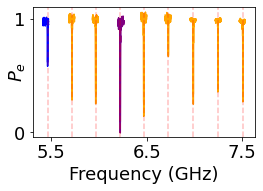

In [2]:
FOLDER_PATH2 = "collected_data\\Fig1\\"

expt_name = 'cavity_spectroscopy_resolved_qubit_pulse'

filelist = [7,8,9,2,4,10,15,16,17]

nu_cav = []

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
show = 'I'

colors = ['blue','purple']

for ii,i in enumerate(filelist):
    filename = FOLDER_PATH2 + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ts  = datetime.fromtimestamp(os.path.getctime(filename)).strftime('%Y-%m-%d %H:%M:%S')
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        nu_c = quantum_device_cfg['flux_pulse_info'][expt_cfg['on_cavities']]['cavity_freqs'][expt_cfg['mode_index']]
        alpha = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['anharmonicity']
        nu_r = quantum_device_cfg['readout']['freq']
        expt_cfg = experiment_cfg[expt_name]
        amp = expt_cfg['cavity_amp']
        length = expt_cfg['cavity_pulse_len']     

        P = array(a[show])
        df = arange(expt_cfg['start'], expt_cfg['stop'], expt_cfg['step'])[:(len(P))]
        freqs = nu_c + df
        if ii is 0:color = colors[0]
        elif ii is 3: color = colors[1]
        else:color = 'orange'

        ax.plot(freqs,P,'-',color = color)

        p = fitlor(freqs,-P,showfit=False)
        plot(freqs, -lorfunc(p,freqs),'-',color = color)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('$P_e$', labelpad=-13)
        print ("Resonance frequency = ",p[2])
        print ("Width = ",p[3]*1e3,"MHz")
        print ("========================================")
        ax.axvline(p[2],color='r',linestyle='dashed',alpha=0.25)
        nu_cav.append(p[2])

        ax.set_ylim(-0.5,1.15)
        ax.set_yticks([0,0.5,1.0])
#         ax.spines["top"].set_visible(False)
#         ax.spines["right"].set_visible(False)
        ax.set_xticks([5.5,6.5,7.5])

      
        ax.set_yticks([-0.44, 1])
        ax.set_yticklabels([0,1])

tight_layout()

nu_cav = array(nu_cav)
# plt.savefig("Main_Figures/Fig1_spec_resubmission.pdf",dpi = 400,bbox_inches='tight')

# Fig 2

C:\Users\slab\anaconda3\envs\slab\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[]

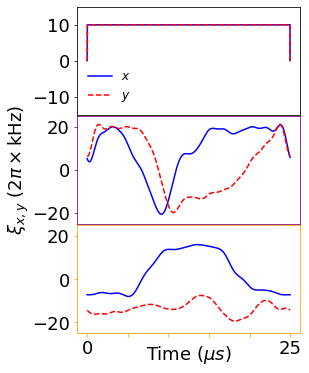

In [29]:
FOLDER_PATH2 = "collected_data\\Fig2\\"
filenames =["00001_g0_to_g1_blockade_omega2_filt3.h5","00000_g0_to_g2_blockade_mode_3_filt3.h5"]
colors= ['b','r']
colors2= ['purple','orange']
lss = ['-','--']

m = multimode_optimal_control_qutip_tests(2,5,1,hparams=None,t1params = None,ROTATING=True,SAMPLE_RATE = 1)

fig,axs = plt.subplots(3,1,figsize = (4,6.0))
fig.subplots_adjust(wspace=0,hspace=0.015)
labels = ['$x$','$y$']
for ii,fn in enumerate(filenames):
    ii+=1
    filename = FOLDER_PATH2 +fn
    ps = np.array(m.return_pulses(filename))/2/pi
    ts = m.tlist/1e3
    for pp,p in enumerate(ps):
        axs[ii].plot(ts[:-50],p[:-50]*1e6,label = labels[pp],color = colors[pp],ls = lss[pp])
   
   
    axs[ii].set_ylim(-25,25)
    axs[ii].set_yticks([-20,0,20])
    axs[ii].set_xticks([0,5,10,15,20,25])
    axs[ii].set_xticklabels([0,'','','','',25])
    
    axs[ii].yaxis.labelpad = 0.5
    if ii is 0:
        axs[ii].legend(loc =4,frameon = False)
        axs[ii].set_xticks([])
    elif ii is 2:
        axs[ii].set_xlabel('Time ($\\mu s$)')
        axs[ii].xaxis.set_label_coords(0.5,-0.1)
    else:
        axs[ii].set_ylabel('$\\xi_{x,y}$ ($2\pi \\times$kHz)')
        axs[ii].set_xticks([])

    if ii in [1,2]:
        axs[ii].spines['bottom'].set_color(colors2[ii-1])
        axs[ii].spines['top'].set_color(colors2[ii-1]) 
        axs[ii].spines['left'].set_color(colors2[ii-1])
        axs[ii].spines['right'].set_color(colors2[ii-1])
        axs[ii].tick_params(colors=colors2[ii-1])
        plt.setp(axs[ii].get_xticklabels(), color="k")
        plt.setp(axs[ii].get_yticklabels(), color="k")


ax = axs[0]

t = ts[:-50]
xi_x = 10*ones(len(t))
xi_x[:10] = 0.0
xi_x[-10:]=0.0
xi_y = xi_x
ax.plot(t,xi_x,label = labels[0],color = colors[0],ls = lss[0])
ax.plot(t,xi_y,label = labels[1],color = colors[1],ls = lss[1])
ax.set_ylim(-15,15)
ax.legend(fontsize = 12,frameon = False)
ax.set_xticks([])
    
# plt.savefig("Main_Figures/fig3_raw_b2.pdf",dpi = 400,bbox_inches='tight')

================================== file num =  15  ================================== 
use weak drive for dressing: True
mode index: 3
S:\Vatsan\IPython Notebooks\Optimal Control\QOC_pulses\00001_g0_to_g1_blockade_omega2_filt3.h5
total pulse time:  25.0
S:\Vatsan\IPython Notebooks\Optimal Control\QOC_pulses\00000_g0_to_g2_blockade_mode_3_filt3.h5
total pulse time:  25.0


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:146: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:146: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 2200.
  warnings.warn(errors[info][0], RuntimeWarning)


================================== file num =  6  ================================== 
use weak drive for dressing: True
mode index: 3
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00000_wigner_points_nmax_7_nexpt_75_kappa_1pt6_gauss.h5
[1, 0.5, 1, 0.4]
True
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/drive_calibrations/00000_cavity_transfer_calibration_max0.5gauss_mode3.h5
DRIVE PHASE =  0 rad
cavity offset freq: 0.0
dressing amp: 0.18
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00000_wigner_points_nmax_7_nexpt_75_kappa_1pt6_gauss.h5
[1, 0.5, 1, 0.4]
True
Alpha =  (-0.12592794935474563+0.13106771369819725j)
Rotating by angle:  2.3361977354432324
(0.9999999999999983-2.6214402798206266e-17j)
[ 9.08718638e-01+7.33592660e-17j  5.49267991e-02+2.39739583e-18j
  3.57894352e-02-3.51613011e-17j  5.65127431e-04-6.42411425e-17j
 -2.82536428e-18-4.04290416e-18j  1.23016448e-19+1.94921932e-18j

C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999972-4.304417916424016e-17j)
[ 9.02221429e-01-2.91651746e-18j  6.54089814e-02+8.08167930e-17j
  3.23695894e-02-1.11883266e-16j -1.11685615e-17-6.43293829e-18j
  4.65801773e-18-4.18094552e-18j -4.51452101e-19-5.88234369e-19j
  1.29166893e-18-1.94222964e-18j]
[0.81822081-4.70900740e-18j 0.08149168+2.43945489e-19j
 0.01280847-1.89735380e-17j 0.02036476+1.27393755e-18j
 0.03399533+1.79045862e-17j 0.03002564-3.89467333e-17j
 0.00309331+1.62630326e-19j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.999999999999999-1.2115473802539526e-16j)
[ 8.95934595e-01-8.12473875e-17j  9.23279275e-02+1.45479110e-17j
  1.17374771e-02-6.47733033e-17j -6.33554181e-17+8.14263501e-18j
  1.41817681e-17-9.34514086e-19j -1.32755722e-18+1.62333372e-18j
  6.76114934e-19-1.99757583e-18j]
[0.60807275-4.58865970e-17j 0.2368364 -3.49079218e-17j
 0.05832623-1.23056947e-17j 0.02101169-1.78236548e-17j
 0.04702957+2.72534618e-18j 0.02193801-5.25838054e-18j
 0.00678534-7.69783542e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999968-1.5947750262863748e-17j)
[ 8.68856825e-01-8.70777757e-17j  1.17924445e-01+1.18225966e-16j
  1.32187302e-02-4.25125582e-17j -7.77052734e-17-1.86935715e-18j
 -2.55574868e-17-5.95147470e-18j -9.29786456e-18+2.27953151e-18j
  1.76455492e-18-1.14309291e-18j]
[0.36235167-4.06489542e-17j 0.29326276-2.08708918e-17j
 0.2293708 -1.68051337e-17j 0.04684499+4.01967955e-17j
 0.04757023+4.32808823e-17j 0.01535928-9.75359504e-18j
 0.00524027-1.13468534e-17j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999982+2.406574225234892e-16j)
[ 8.80238225e-01+1.23821177e-16j  8.69046692e-02+1.43330782e-16j
  3.28571059e-02-1.04340342e-17j -8.22423550e-17+8.36976005e-18j
  1.65230774e-17-1.54547117e-17j  4.26775500e-18+1.91622436e-19j
 -1.77933015e-20-1.22787243e-19j]
[0.22276502+2.53601664e-17j 0.23172247+3.79470760e-17j
 0.43799602+6.50148720e-17j 0.04712185+6.59443264e-17j
 0.03750931+4.77150600e-17j 0.01823835-2.82840883e-18j
 0.00464698+1.50433051e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999989+1.7396276926290337e-16j)
[8.99873343e-01+1.20170010e-17j 7.22654994e-02+1.76060878e-16j
 2.78611575e-02-1.47151147e-18j 2.99898639e-19-4.99304218e-17j
 3.74090383e-17+3.94782679e-17j 1.49082039e-18+4.88492656e-19j
 3.44778310e-20+9.59612881e-21j]
[0.11126376+1.12485975e-18j 0.17044735+2.81892565e-17j
 0.62983787+1.74592905e-17j 0.0272428 +8.78916677e-18j
 0.04906999+9.98789733e-17j 0.01108346+1.86211723e-17j
 0.00105477-9.99498878e-20j]
================================== file num =  24  ================================== 
use weak drive for dressing: True
mode index: 3
[    0.  1000.  3000.  5000.  7000.  9000. 11000. 13000. 15000. 17000.
 19000. 21000. 23000. 25000.]
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00000_wigner_points_nmax_7_nexpt_75_kappa_1pt6_gauss.h5
[1, 0.5, 1, 0.4]
True
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/drive_calibrations/00000_cavity_transfer_calibration_max0.5gauss_mode3.h

C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999987-1.1609798089126385e-16j)
[ 9.02036421e-01-6.46671838e-17j  2.82084650e-02+9.85401164e-17j
  6.97551139e-02-1.43036711e-16j  6.02509053e-17-3.37334156e-18j
 -3.72477588e-18+9.67776316e-19j  7.17479719e-19+2.80795796e-18j
  3.14530716e-19-2.22948780e-18j]
[0.80207397-5.85838155e-17j 0.09252931-5.58364119e-18j
 0.01662015-1.90345244e-17j 0.01185823-9.81202966e-18j
 0.03816011-4.88830789e-17j 0.03224235+2.67748906e-17j
 0.00651587-9.75781955e-19j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999977-1.6849604201075596e-16j)
[ 8.61836430e-01-1.04286966e-16j  1.10077419e-01+1.62016157e-16j
  2.80861508e-02-2.25722934e-16j  8.05334970e-17+6.27620433e-18j
 -1.00064631e-17-5.29236508e-18j -9.96694510e-19+1.50769398e-18j
  1.82747903e-18-3.75444403e-19j]
[0.58962026-7.58270307e-17j 0.22711773-4.20670443e-17j
 0.05652358-2.21177243e-17j 0.03690853-9.86623977e-18j
 0.05959423+2.71255887e-17j 0.02766515-3.10390996e-17j
 0.00257052-1.47044920e-17j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999993+2.2808145591468504e-16j)
[ 8.64619877e-01-1.73360844e-16j  1.04111788e-01+1.65371942e-16j
  3.12683351e-02+2.21299850e-16j -3.33818770e-17+1.58626871e-17j
  2.05733241e-17-9.09291213e-18j  4.04501858e-18-3.96172019e-19j
 -1.02203277e-19+2.38973058e-19j]
[0.31994541-4.28259858e-17j 0.3830763 -2.42781392e-17j
 0.17735677-2.27682456e-18j 0.01969118+6.42050974e-17j
 0.04803553+1.02034079e-16j 0.04616493+1.07416522e-16j
 0.00572989+2.38067080e-17j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999981+2.7346609200270834e-16j)
[ 8.62702264e-01-9.07386835e-17j  1.13908719e-01+2.52692854e-16j
  2.33890169e-02+1.11332184e-16j  1.06255790e-16-4.28663570e-18j
  8.45235154e-18+1.20799519e-18j -5.69462865e-18-4.98890016e-19j
  2.88335815e-19+8.64164604e-20j]
[0.1336574 -6.98293962e-18j 0.54822635-3.43368994e-17j
 0.20065748+2.25514052e-17j 0.0449027 +1.03405782e-16j
 0.05048547+1.11652490e-16j 0.02061013+7.10098535e-17j
 0.00146047+6.16639986e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999967+1.0371849246589706e-16j)
[ 8.86841688e-01-8.81398506e-17j  7.69462756e-02-2.01270689e-16j
  3.22845639e-02+1.44424264e-16j  3.92747288e-03+1.04579856e-16j
 -3.50673293e-17+3.59272260e-18j -3.21685166e-18-7.82847083e-18j
  1.47151998e-18+4.48190493e-18j]
[0.0229647 +2.26666017e-17j 0.87494452+4.48211519e-17j
 0.01336451+5.86186373e-17j 0.02471896+2.70937731e-17j
 0.02400171-1.93950612e-17j 0.01918728-5.69206141e-18j
 0.02081831-2.43945489e-17j]
================================== file num =  26  ================================== 
use weak drive for dressing: True
mode index: 3
[    0.  1000.  3000.  5000.  7000.  9000. 11000. 13000. 15000. 17000.
 19000. 21000. 23000. 25000.]
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00000_wigner_points_nmax_7_nexpt_75_kappa_1pt6_gauss.h5
[1, 0.5, 1, 0.4]
True
S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/drive_calibrations/00000_cavity_transfer_calibration_max0.5gauss_

C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999963-1.6540145197866805e-16j)
[ 8.73887463e-01-4.32881086e-17j  7.91533495e-02-9.09782420e-17j
  4.31347560e-02-4.86798531e-17j  3.82443176e-03+8.87804172e-18j
  5.05760898e-17+2.22624744e-19j -7.93560351e-18+1.05862991e-18j
  1.55541742e-18-7.23429012e-19j]
[0.73148613-3.66129885e-17j 0.12369681-7.72494048e-18j
 0.02263102-1.96892092e-18j 0.02935989-2.83247818e-17j
 0.03978106-3.81571713e-17j 0.04695643-4.70501837e-17j
 0.00608867-5.56246536e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.999999999999998-7.992816708001984e-17j)
[ 8.91936755e-01+3.96134566e-17j  8.96679344e-02+4.57393622e-17j
  1.83953101e-02-1.56529391e-16j -3.22645733e-17-1.26584787e-17j
  6.35742482e-18-1.03864209e-18j -1.56442895e-18-6.60734490e-19j
  8.26806433e-19+5.44960275e-19j]
[0.47974696+1.62995217e-17j 0.3028138 +5.85469173e-18j
 0.10848114-2.58311168e-17j 0.04019872-4.01154804e-17j
 0.05088067+1.95148602e-17j 0.01610568-5.45060903e-17j
 0.00177304-1.14455327e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999979-7.391752202946447e-17j)
[ 8.56539108e-01-1.09996978e-16j  1.12203949e-01+2.01897918e-17j
  2.71810864e-02+9.54626596e-18j  4.07585637e-03-3.14418460e-17j
 -1.72908873e-17+4.23071063e-17j -1.16369968e-18-8.00865651e-18j
 -3.14105242e-18+2.84195621e-18j]
[0.21138666-2.92463536e-17j 0.25336051-2.48824399e-17j
 0.39558699-4.47755737e-17j 0.04315765+6.03087458e-18j
 0.05335148+7.41405187e-18j 0.03747296+1.28749008e-17j
 0.00568374-1.33298216e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999973-1.443626781395634e-16j)
[ 8.34145863e-01+1.07092027e-17j  8.70523719e-02-1.51687834e-16j
  5.45001053e-02+1.93713286e-16j  2.43016598e-02-2.03973704e-16j
 -8.60419015e-17-1.43344257e-17j  5.13547899e-18-4.52140594e-18j
 -2.38617166e-18+9.94247620e-19j]
[0.11363013+1.22679507e-16j 0.1205032 -1.23599048e-17j
 0.62679252+1.44401730e-17j 0.04732702-1.18946861e-16j
 0.07052803-8.37402571e-17j 0.01647899-6.49648860e-17j
 0.0047401 -1.47044920e-18j]


C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:152: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:156: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\ipykernel_launcher.py:56

(0.9999999999999973-2.5760772760099074e-16j)
[ 8.63887773e-01-9.79017942e-17j  7.88198004e-02+1.87669438e-16j
  5.72924265e-02-3.30000970e-16j -2.13176578e-17+9.78189099e-18j
  7.29291273e-18-1.14933723e-18j  1.12885450e-18+2.19586210e-18j
  3.21511786e-19-7.46722707e-19j]
[0.00410906-4.60785923e-19j 0.00510307-1.72252620e-17j
 0.85664338-8.74795784e-17j 0.05467776-7.26008880e-17j
 0.06631666-5.53687374e-17j 0.0050085 -4.36391374e-18j
 0.00814156-2.01085622e-17j]


[Text(-0.6366197723675814, 0, '-$\\frac{2}{\\pi}$'),
 Text(0.0, 0, '0'),
 Text(0.6366197723675814, 0, '$\\frac{2}{\\pi}$')]

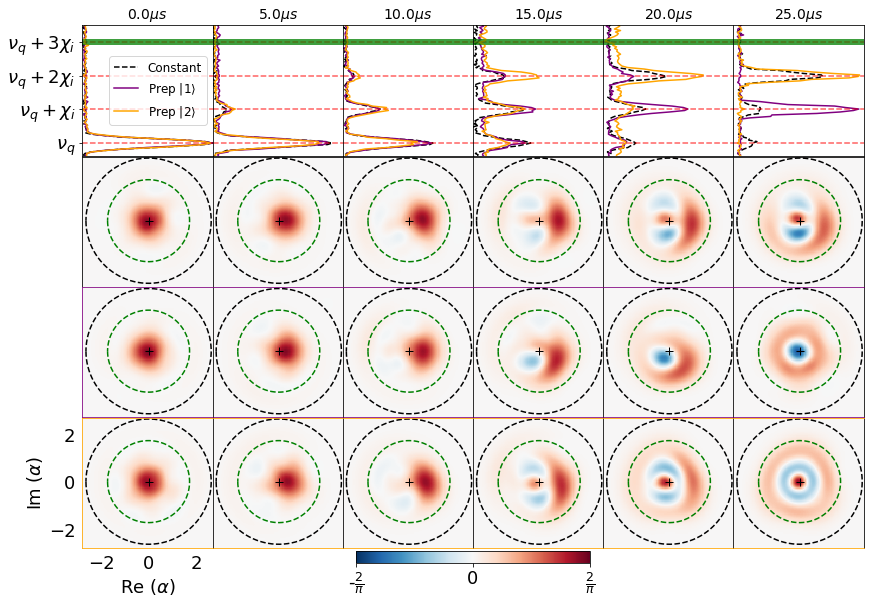

In [17]:
FOLDER_PATH = "collected_data\\Fig2\\"

tp = linspace(0,25,6)
Pnorm = 0.96702893
shows = ['I']
pops = []
colors = ['k','purple','orange']
lss = ['--','-','-']
fig,axs = plt.subplots(4,len(tp),figsize=(14,11.39))
fig.subplots_adjust(wspace=0.0,hspace=-0.01)
labels =  ['Constant','Prep $\\left|1\\right>$','Prep $\\left|2\\right>$'] 
dalpha = 0.05

expt_name = 'sequential_multitone_blockaded_weak_cavity_pnrqs'
filelist = [15]

show = 'I'
gamma = 0.00013242056959782576
Psss,freqss = [],[]
for ff,i in enumerate(filelist):
    filename = FOLDER_PATH + str(i).zfill(5) + "_"+expt_name.lower()+".h5"


    with File(filename,'r') as a:
        
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multitone_blockaded_weak_cavity_pnrqs']
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        chiges = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        print ("================================== file num = ",i," ================================== ")
        print ("use weak drive for dressing:",expt_cfg['use_weak_drive_for_dressing'])
        print("mode index:", expt_cfg['mode_index'])
        chi = chiges[expt_cfg['mode_index']]

        I = array(a[show])/Pnorm
        f = np.arange(expt_cfg['start'], expt_cfg['stop'], expt_cfg['step']) + nu_q
        ts = np.arange(swp_cfg['start'], swp_cfg['stop'], swp_cfg['step'])
        Ns = 3*ones(len(I))
        Ns[0] = 1
        Ns[1] = 2 
                
        for tt,t in enumerate(tp):
            ind = argmin(abs(ts/1e3-t))
        
            ax = axs[0][tt]
            i = I[ind]
            if tt is 0:ax.plot(i,f,color = colors[ff],label = labels[ff],ls = lss[ff])
            else:ax.plot(i,f,ls = lss[ff],color = colors[ff])
            if tt is 0:
                ax.set_yticks([nu_q+2*jj*chi for jj in range(4)])
                ax.set_yticklabels(['$\\nu_q$','$\\nu_q + \\chi_i$','$\\nu_q + 2\\chi_i$','$\\nu_q + 3\\chi_i$'])
                
            else: ax.set_yticks([])
#             ax.set_xlabel(str(around(t,1))+'$\\mu s$',fontsize=14)
            for jj in range(10):
                ax.axhline(nu_q+2*jj*chi,color='r',linestyle='dashed',alpha=0.25)
                
            ax.set_ylim(f[-1],f[10])
            if tt is 0:ax.legend(fontsize = 12,frameon=True,loc=7)
                
                
            N = int(Ns[tt])
            def gaussfuncsum(p, x):
                y = 0
                for ii in range(N):
                    y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)

                return y

            def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
                if domain is not None:
                    fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
                else:
                    fitdatax=xdata
                    fitdatay=ydata
                if fitparams is None:
                    fitparams=0*ones(3*N+1)
                    fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
                    fitparams[1]=max(fitdatay)-min(fitdatay)
                    fitparams[2]=fitdatax[np.argmax(fitdatay)]
                    fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
                if debug==True: print(fitparams)
                p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                                label=label)
                p1[3]=abs(p1[3])
                return p1
                
            p = 0*ones(3*N+1)
            for ii in range(N):
                p[3*ii+1] = 1
                p[3*ii+2] = nu_q + 2*chi*ii
                p[3*ii+3] = 0.0001

            p = fitgausssum(f,i,fitparams = p,showfit=False)
            pop = p[1::3]
            f2 = linspace(f[0],f[-1],1000)
#             ax.plot(gaussfuncsum(p,f2),f2,'-',alpha=0.5,color = colors[ff])
            
            pops.append(pop)
            ax.set_xticks([])
            ax.set_title(str(around(t,1))+'$\\mu s$',fontsize=14)
            ax.set_xlim(-0.025, 1)



expt_name = 'sequential_optimal_control_test_with_blockade'
filelist = [25,27]

for ff,i in enumerate(filelist):
    ff +=1
    filename = FOLDER_PATH + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_test_with_blockade_1step']
        print (expt_cfg['filename'])
        pulse_file = FOLDER_PATH + expt_cfg['filename'].split("\\")[-1]
        with File(pulse_file, 'r') as oc_file:
            end_time = oc_file['total_time'][()]/1e3
            print("total pulse time: ", end_time)
        nu_c = quantum_device_cfg['flux_pulse_info']['1']['cavity_freqs'][expt_cfg['mode_index']]
        chi = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e'][expt_cfg['mode_index']]
        I,Q = array(a['I']),array(a['Q'])
        f = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:] + nu_q
        steps = swp_cfg['steps']
        Ns = 3*ones(len(I))
        Ns[0] = 1
        Ns[1] = 2 
        
        I = I/Pnorm

        ts = np.array(swp_cfg['pulse_fracs']) * 25000  
        
        
        for tt,t in enumerate(tp):
            ind = argmin(abs(ts/1e3-t))
        
            ax = axs[0][tt]
            i = I[ind]
            if tt is 0:ax.plot(i,f,'-',color = colors[ff],label = labels[ff],ls = lss[ff])
            else:ax.plot(i,f,'-',color = colors[ff])
            if tt is 0:
                ax.set_yticks([nu_q+2*jj*chi for jj in range(4)])
                ax.set_yticklabels(['$\\nu_q$','$\\nu_q + \\chi_i$','$\\nu_q + 2\\chi_i$','$\\nu_q + 3\\chi_i$'])
                
            else: ax.set_yticks([])
#             ax.set_xlabel(str(around(t,1))+'$\\mu s$',fontsize=14)
            for jj in range(10):
                ax.axhline(nu_q+2*jj*chi,color='r',linestyle='dashed',alpha=0.25)
                
            ax.set_ylim(f[-1],f[10])
            if tt is 0:ax.legend(fontsize = 12,frameon=True,loc=7)
                
                
            N = int(Ns[tt])
            def gaussfuncsum(p, x):
                y = 0
                for ii in range(N):
                    y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)

                return y

            def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
                if domain is not None:
                    fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
                else:
                    fitdatax=xdata
                    fitdatay=ydata
                if fitparams is None:
                    fitparams=0*ones(3*N+1)
                    fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
                    fitparams[1]=max(fitdatay)-min(fitdatay)
                    fitparams[2]=fitdatax[np.argmax(fitdatay)]
                    fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
                if debug==True: print(fitparams)
                p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                                label=label)
                p1[3]=abs(p1[3])
                return p1
                
            p = 0*ones(3*N+1)
            for ii in range(N):
                p[3*ii+1] = 1
                p[3*ii+2] = nu_q + 2*chi*ii
                p[3*ii+3] = 0.0001

            p = fitgausssum(f,i,fitparams = p,showfit=False)
            pop = p[1::3]
            f2 = linspace(f[0],f[-1],1000)
#             ax.plot(gaussfuncsum(p,f2),f2,'-',alpha=0.5,color = colors[ff])
            
            pops.append(pop)
            ax.set_xticks([])
            ax.set_title(str(around(t,1))+'$\\mu s$',fontsize=14)
            ax.set_xlim(-0.025, 1)
            ax.axhline(nu_q + 2*chi*expt_cfg['blockade_params']['levels'][0],color='g',linewidth=6,alpha=0.5)
            
expt_name = 'sequential_blockade_experiments_with_optimal_control_wt'
filelist = [6]

mode_state_num = 7
pops_wt = []
show = 'I'

for ff,i in enumerate(filelist[:]):
    ff+=1
    filename = FOLDER_PATH + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['blockade_experiments_with_optimal_control_wt']
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        chiges = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        print ("================================== file num = ",i," ================================== ")
        print ("use weak drive for dressing:",expt_cfg['use_weak_drive_for_dressing'])
        print("mode index:", expt_cfg['mode_index'])
        Pss = array(a[show])
        ts = np.arange(swp_cfg['start'], swp_cfg['stop'], swp_cfg['step'])
        r1 = sqrt(mode_state_num)
        r2 = sqrt(3)
        
#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        wigner_pts_file = FOLDER_PATH + "00000_wigner_points_nmax_7_nexpt_75_kappa_1pt6_gauss.h5"
        print (expt_cfg['wigner_points_file_name'])
        print(hardware_cfg['awg_info']['m8195a']['amplitudes'])
        print(expt_cfg['transfer_fn_wt'])
        print(experiment_cfg['transfer_function_blockade_calibration_files']['cavity_amp_vs_freq_list'][expt_cfg['mode_index']])
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y

        print ("DRIVE PHASE = ",expt_cfg['phase'],"rad")
        print("cavity offset freq:", expt_cfg['cavity_offset_freq'])
        print("dressing amp:", expt_cfg['dressing_amp'])

        w = wigner_tomography_analysis(alphas, mode_state_num=mode_state_num, analytic=True)
        
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y
        alphas2 = arange(-r1-0.1,+r1+0.1,dalpha)
        

#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        print (expt_cfg['wigner_points_file_name'])
        print(hardware_cfg['awg_info']['m8195a']['amplitudes'])
        print(expt_cfg['transfer_fn_wt'])
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y
        
        index_to_use_for_fit = 5
        fit_angle_dat = Pss[index_to_use_for_fit]
        fit_angle_W = -2/pi * (2 * fit_angle_dat - 1)
        rho = w.rho_pinv_positive_sd(fit_angle_W)
        a_op = np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)
        expected_alpha = np.trace(np.matmul(a_op, rho))
        print("Alpha = ", expected_alpha)
        rotate_angle = np.arctan2(np.imag(expected_alpha), np.real(expected_alpha))
  
        print("Rotating by angle: ", rotate_angle)
        alphas = alphas*exp(1j*rotate_angle)
            
        w = wigner_tomography_analysis(alphas,mode_state_num = mode_state_num)
        
        P_ns =[]
        for ii,t in enumerate(tp):
            ind = argmin(abs(ts/1e3-t))
            Ps = Pss[ind]
            W = -2/pi*(2*Ps-1)

            rho = w.rho_pinv_positive_sd(W)
            print (trace(rho))
            print (eig(rho)[0])
            print (array([rho[i][i] for i in range(mode_state_num)]))
            if ff is 0:
                axs[ff][ii].set_title('$\\tau$ = '+str(around(t, 0)) +' $\\mu s$',fontsize = 15)
          

            
            cax = axs[ff][ii].pcolormesh(alphas2-dalpha/2.0,alphas2-dalpha/2.0,real(w.extracted_W(rho,alphas2,alphas2)),cmap = 'RdBu_r',vmin = -2/np.pi,vmax = 2/np.pi)
            th = linspace(-3.14,3.14,100)
            axs[ff][ii].plot(r1*cos(th),r1*sin(th),'k--')
            axs[ff][ii].plot(r2*cos(th),r2*sin(th),'g--')
            axs[ff][ii].plot(0,0,marker = '+',ms = 8.5,color ='k')
   
#             fig3.colorbar(c,ax=ax3)
           
            axs[ff][ii].set_ylim(-r1,r1)
            axs[ff][ii].set_xlim(-r1,r1)
       
            axs[ff][ii].set_xticks([])
            axs[ff][ii].set_yticks([])
            axs[ff][ii].yaxis.set_ticks_position('none')
            axs[ff][ii].xaxis.set_ticks_position('none')
            axs[ff][ii].axis('scaled')
            

filelist = [24,26]

mode_state_nums = [7,7]
expt_name = 'sequential_optimal_control_test_with_blockade'

show = 'I'

for fff,i in enumerate(filelist[:]):
    ff=fff+2
    filename = FOLDER_PATH + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    
#     plotlist = plotlistlist[fff]
    mode_state_num = mode_state_nums[fff]
    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_test_with_blockade_1step']
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        chiges = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        print ("================================== file num = ",i," ================================== ")
        print ("use weak drive for dressing:",expt_cfg['use_weak_drive_for_dressing'])
        print("mode index:", expt_cfg['mode_index'])
        Pss = array(a[show])
#         ts = np.arange(swp_cfg['steps'] + 1) * 25000 / swp_cfg['steps']
        ts = np.array(swp_cfg['pulse_fracs']) * 25000       
        print (ts)
        r1 = sqrt(mode_state_num)
        r2 = sqrt(3)

#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        wigner_pts_file = FOLDER_PATH + "00000_wigner_points_nmax_7_nexpt_75_kappa_1pt6_gauss.h5"
        print (expt_cfg['wigner_points_file_name'])
        print(hardware_cfg['awg_info']['m8195a']['amplitudes'])
        print(expt_cfg['transfer_fn_wt'])
        print(experiment_cfg['transfer_function_blockade_calibration_files']['cavity_amp_vs_freq_list'][expt_cfg['mode_index']])
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y
        alphas2 = arange(-r1-0.1,+r1+0.1,dalpha)

        print (expt_cfg['wigner_points_file_name'])
        print(hardware_cfg['awg_info']['m8195a']['amplitudes'])
        print(expt_cfg['transfer_fn_wt'])
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y

        w = wigner_tomography_analysis(alphas,mode_state_num = mode_state_num)
        
        fit_angle_dat = Pss[index_to_use_for_fit]
        fit_angle_W = -2/pi * (2 * fit_angle_dat - 1)
        rho = w.rho_pinv_positive_sd(fit_angle_W)
        a_op = np.diag(np.sqrt(np.arange(1, mode_state_num)), 1)
        expected_alpha = np.trace(np.matmul(a_op, rho))
        print("Alpha = ", expected_alpha)
        rotate_angle = np.arctan2(np.imag(expected_alpha), np.real(expected_alpha))
        print("Rotating by angle: ", rotate_angle)
        alphas = alphas*exp(1j*rotate_angle)
        
        w = wigner_tomography_analysis(alphas,mode_state_num = mode_state_num)
        
        P_ns = []
        for ii,t in enumerate(tp):
            ind = argmin(abs(ts/1e3-t))
            Ps = Pss[ind]
            W = -2/pi*(2*Ps-1)
        
            rho = w.rho_pinv_positive_sd(W)
            print (trace(rho))
            print (eig(rho)[0])
            print (array([rho[i][i] for i in range(mode_state_num)]))
            if ff is 0:
                axs[ff][ii].set_title('$\\tau$ = '+str(around(t[ww], 0)) +' $\\mu s$',fontsize = 15)
            
            cax = axs[ff][ii].pcolormesh(alphas2-dalpha/2.0,alphas2-dalpha/2.0,real(w.extracted_W(rho,alphas2,alphas2)),cmap = 'RdBu_r',vmin = -2/np.pi,vmax = 2/np.pi)
            th = linspace(-3.14,3.14,100)
            axs[ff][ii].plot(r1*cos(th),r1*sin(th),'k--')
            axs[ff][ii].plot(r2*cos(th),r2*sin(th),'g--')
            axs[ff][ii].plot(0,0,marker = '+',ms = 8.5,color ='k')
   
#             fig3.colorbar(c,ax=ax3)
           
            axs[ff][ii].set_ylim(-r1,r1)
            axs[ff][ii].set_xlim(-r1,r1)
       
            axs[ff][ii].set_xticks([])
            axs[ff][ii].set_yticks([])
            axs[ff][ii].yaxis.set_ticks_position('none')
            axs[ff][ii].xaxis.set_ticks_position('none')
            axs[ff][ii].axis('scaled')
            ax = axs[ff][ii]
            
            ax.spines['bottom'].set_color(colors[fff+1])
            ax.spines['top'].set_color(colors[fff+1]) 
            if ii is 0:
                ax.spines['left'].set_color(colors[fff+1])
            if ii is len(tp):
                ax.spines['right'].set_color(colors[fff+1])
            
            
axs[3][0].set_xlabel('$\\mathrm{Re}$ $(\\alpha)$')
axs[3][0].set_ylabel('$\\mathrm{Im}$ $(\\alpha)$')
axs[3][0].set_xticks([-2,0,2])
axs[3][0].set_yticks([-2,0,2])
# plt.tight_layout()
    
cbar = fig.colorbar(cax, ax=axs.ravel().tolist(),shrink=0.3, ticks=[-2/pi,0,2/pi],orientation='horizontal',pad=+0.005)
cbar.ax.set_xticklabels(['-$\\frac{2}{\pi}$','0','$\\frac{2}{\pi}$'])
# plt.savefig("Main_Figures/fig3_raw2.pdf",dpi = 400,bbox_inches='tight')

# Fig 3

weak cavity drive: True
weak cavity drive: True
weak cavity drive: True
weak cavity drive: True
baseline =  0.058619246991956586


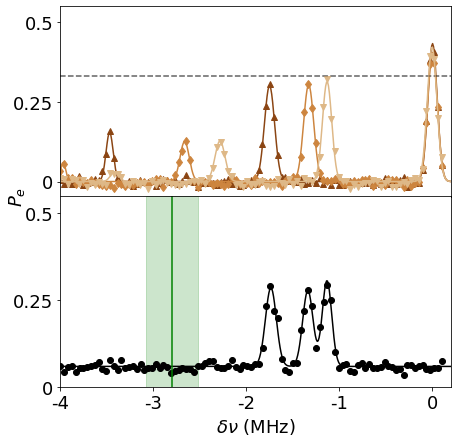

In [9]:
FOLDER_PATH = "collected_data\\Fig3\\"

expt_name = 'multitone_multimode_blockaded_cavity_pnrqs'

filelist = [7,8,9]

shows = ['I']
Ns = [4] * len(filelist)
pops = []
nus = []
poplist =[]
colors = ['cornflowerblue','royalblue','navy']
# colors = ['lightgrey','darkgrey','dimgrey']
colors = ['saddlebrown','peru','burlywood']
markers = ['^','d','v']
fig,axs = plt.subplots(2,1,figsize = (7,7))
fig.subplots_adjust(wspace=-0.05,hspace=-0.01)
ax = axs[0]
for ff,i in enumerate(filelist):
    filename = FOLDER_PATH + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name]
        print ('weak cavity drive:',expt_cfg['use_weak_cavity'])

        nu_q = quantum_device_cfg['qubit']['1']['freq']
        chis = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        I,Q = array(a['I']),array(a['Q'])
        f = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:] + nu_q
        
        mode_indices = expt_cfg['blockade_mode_indices']
        chis = array([quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e'][mode_index] for mode_index in mode_indices])

        I,Q = array(a['I']),array(a['Q'])
        I = I-median(I)
        I = I/Pnorm
        N = 4
        f = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:] + nu_q
        p = 0*ones(3*N+1)
        chi = chis[ff]
        for ii in range(N):
            if ii is 1:
                p[3*ii+1] = 1
            else:p[3*ii+1] = 0
            p[3*ii+2] = nu_q + 2*chi*ii
            p[3*ii+3] = 0.0001
            
   
        f2 = arange(4.985,4.991,0.00001)
       
        ax.plot(f,I,markers[ff],color=colors[ff],alpha  = 1,ms = 6.0)
        p = fitgausssum(f,I,fitparams = p,showfit=False)
        ax.plot(f2, gaussfuncsum(p,f2),color = colors[ff],alpha = 1)
        pfit = p
        Y = abs(pfit[2::3])
        X = abs(pfit[1::3])
        pops = [x for y,x in sorted(zip(-Y,X))]
        nus = -sort(-Y)
        poplist.append(pops)
        ax.set_ylim(-0.05,0.55)
        ax.set_yticks([0.0,0.25, 0.5])
        ax.axhline(0.33,color='k',alpha = 0.25,linestyle='dashed')
        ax.set_yticklabels(['0','0.25','0.5'])
       
        ax.set_xlim(4.986298,nu_q+0.0002)

#         print ("baseline = ",bline)
        ax.set_xticks([])

 
        
expt_name = 'multitone_multimode_blockaded_cavity_pnrqs'

filelist = [10]

shows = ['I']
Ns = [3] * len(filelist)
pops = []
nus = []

colors = ['k']

ax = axs[1]

for ff,i in enumerate(filelist):
    filename = FOLDER_PATH + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name]
        print ('weak cavity drive:',expt_cfg['use_weak_cavity'])

        nu_q = quantum_device_cfg['qubit']['1']['freq']
        chis = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        I,Q = array(a['I']),array(a['Q'])
        f = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:] + nu_q
        
        
        mode_indices = expt_cfg['blockade_mode_indices']
        chis = array([quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e'][mode_index] for mode_index in mode_indices])


        I,Q = array(a['I']),array(a['Q'])
        bline = median(I)
        I = I - bline
        I = I/Pnorm
        N = 3
        f = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:] + nu_q
        p = 0*ones(3*N+1)
        for ii in range(N):
            chi = chis[ii]
        
            p[3*ii+1] = 0.3
            p[3*ii+2] = nu_q + 2*chi
#             ax.axhline( p[3*ii+2])
            p[3*ii+3] = 0.0001
            
   
        f2 = arange(4.985,4.991,0.00001)
    
    
       
        ax.plot(f,I+bline,'o',color=colors[ff],ms = 6.0)
        p = fitgausssum(f,I,fitparams = p,showfit=False)
        ax.plot(f2,gaussfuncsum(p,f2)+ bline,color = colors[ff])
        pfit = p
        Y = abs(pfit[2::3])
        X = abs(pfit[1::3])
        pops = [x for y,x in sorted(zip(-Y,X))]
        nus = -sort(-Y)
        poplist.append(pops)
#         ax.set_xlabel('$P_e$')
        pop = p[1::3]

        
        ax.set_xlabel('$\\delta\\nu$ (MHz)')
        ax.set_ylabel('$P_e$')
        pop = p[1::3]
        ax.set_ylim(-0.00,0.55)
        ax.set_yticks([0.0,0.25, 0.5])
#         ax.axhline(0.33,color='k',alpha = 0.25,linestyle='dashed')
        ax.set_yticklabels(['0','0.25','0.5'])
       
        ax.set_xlim(4.986298,nu_q+0.0002)
        ax.axvspan(nu_q + mean(4*chis)-mean(4*chis)/10,nu_q + mean(4*chis)+mean(4*chis)/10,color='g',alpha=0.2)
        ax.axvline(nu_q + mean(4*chis),color='g',alpha=1.0)
        print ("baseline = ",bline)
        ax.set_xticks(nu_q - 0.001*arange(5))
        ax.set_xticklabels([0,-1,-2,-3,-4])

        ax.yaxis.set_label_coords(-0.085,1.00)
        
        
# plt.savefig("Main_Figures/Fig3_spec2.pdf",dpi = 400,bbox_inches='tight')

{'dressing_amps': [[0.0], [0.0], [0.0]], 'cavity_amps': [0.15, 0.13, 0.175], 'cavity_phases': [0.0, 0.0, 0.0], 'stop': 64100.0, 'step': 2100.0, 'pi_calibration': True, 'use_weak_drive_for_dressing': True, 'start': 0.0, 'acquisition_num': 1000, 'on_qubits': ['1'], 'singleshot': False, 'cavity_pulse_type': 'square', 'use_weak_drive_for_probe': True, 'dressing_pulse_type': 'square', 'probe_level': 3.0, 'prep_state_before_blockade': False, 'prep_using_blockade': True, 'prep_mode_index': 5, 'dressing_drive_offset_freqs': [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], 'use_weak_cavity': True, 'cavity_offset_freqs': [0, -4.143961510347468e-05, -2.1163818860406518e-05, -1.2891953560385923e-05, -2.0006939448957504e-05, -7.91305412608604e-06, -1.2082238397375761e-05, -7.252869538656223e-06, 0], 'blockade_mode_indices': [1, 2, 3], 'cavity_drive_mode_indices': [1, 2, 3], 'probe_mode_index': 1, 'blockade_levels': [[2], [2], [2], [2], [2], [2], [2], [2], [2]], 'blockade_pair_sums':

C:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)
C:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


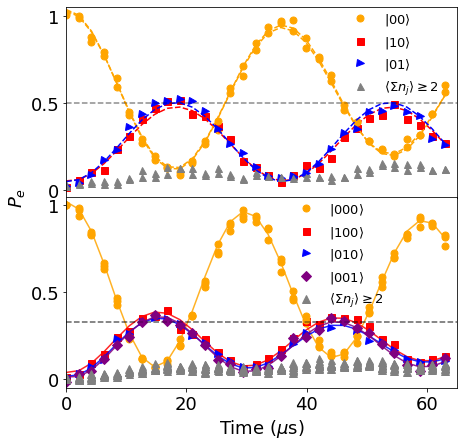

In [10]:
FOLDER_PATH = "collected_data\\Fig3\\"

labelfontsize = 13
matplotlib.rcParams.update({'font.size': 18})
frame_on = False

expt_name = 'sequential_multitone_multimode_blockaded_cavity_rabi_vary_probe_level'
filelist = [53,54,55]
fitlist = [[0,1]] * len(filelist)

show = 'I'

fig,axs = plt.subplots(2,1,figsize=(7,7))
fig.subplots_adjust(wspace=-0.05,hspace=-0.01)

labels = ['000','100',None,None,'010',None,None,'001',None,None]
markers = ['o','s','^','^','>','^','^','D','^','^']
kk=0
ax = axs[1]
colors = ['orange','red','gray','gray','blue','gray','gray','purple','gray','gray']
for ff,f in enumerate(filelist):
    filename = FOLDER_PATH + str(f).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multitone_multimode_blockaded_cavity_rabi']
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        chiges = quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e']
        Pnorm = array(a[show])[0][0]
        P = array(a[show])/Pnorm
        t = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:]/1e3
        ns = arange(swp_cfg['start'],swp_cfg['stop'],swp_cfg['step'])[:]
        
        chiges = array(quantum_device_cfg['flux_pulse_info']['1']['chiby2pi_e'])
        if ff == 0:
            print(expt_cfg)
                
        if expt_cfg['blockade_pair_sums']:
            print("pair dressing amps:", expt_cfg['pair_dressing_amps'])

        for ii,pp in enumerate(P):
            if ii is 0 and ff is not 0:
                ax.plot(t,pp[:len(t)],'o',markersize=7,color = colors[0])
            else:
                if labels[kk] is not None and labels[kk] is not 'special':
                    ax.plot(t,pp[:len(t)],markers[kk],label = '$\\left|' + labels[kk]+'\\right>$',
                            markersize=7,color = colors[kk])
                elif labels[kk] is 'special':
                    ax.plot(t,pp[:len(t)],markers[kk],label='$\\langle \\Sigma n_j \\rangle \\geq 2$',
                            markersize=7,color = colors[kk])
                else:
                    ax.plot(t,pp[:len(t)],markers[kk],
                            markersize=7,color = colors[kk])
                
                if ii in fitlist[ff]:
                    f = fitdecaysin(t,pp,fitparams = [0.5,1/(2*12.0),0,100.0,0.5],showfit=False)
                    if ii is 0:
                        ax.plot(t,decaysin(append(f,0),t),'-',alpha = 0.85,color = colors[0])
                    else:
                        ax.plot(t,decaysin(append(f,0),t),'-',alpha = 0.85,color = colors[kk])
#                     ax.axvline(1/f[1]/2,color='k',linestyle='dashed')
#                     print ("pi length = ",1/f[1]/2.0)
                kk+=1
#         ax.plot(t,sum(P[:2],axis=0),'k--',alpha=0.2)

        ax.set_xlabel('Time ($\\mu$s)')
        ax.set_ylabel('$P_e$')
        ax.yaxis.set_label_coords(-0.1,1.00)
        ax.axhline(0.33,linestyle='dashed',color='k',alpha=0.25)
        ax.set_ylim(-0.05,1.05)
        ax.set_yticks([0,0.5,1])
        ax.set_xlim(0,65)
        ax.set_xticks(arange(0,70,20))


expt_name = 'multitone_multimode_blockaded_cavity_rabi_multiprobe'
filelist = [4,6,5,7]

labels = ['special', None, None, None]
markers = ['^', '^', '^', '^']
colors = ['gray', 'gray', 'gray', 'gray']

show = 'I'
for ff,f in enumerate(filelist):
    filename = FOLDER_PATH + \
                str(f).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]

        P = array(a[show]) 
        t = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:]/1e3
        
        if labels[ff] == 'special':
            ax.plot(t,P[:len(t)], markers[ff], markersize=8, label='$\\langle \\Sigma n_j \\rangle \\geq 2$', 
                    color=colors[ff])
        else:
            ax.plot(t,P[:len(t)], markers[ff], markersize=8, 
                    color=colors[ff])

        f = fitdecaysin(t,P,fitparams = [0.5,1/(2*12.0),0,100.0,0.5],showfit=False)

handles2, labels2 = plt.gca().get_legend_handles_labels()
order2 = range(len(labels2))
ax.legend([handles2[idx] for idx in order2],[labels2[idx] for idx in order2],frameon=frame_on,
          bbox_to_anchor=(0.55,0.35), fontsize=labelfontsize)
ax.set_yticklabels(['0','0.5','1'])


#----------------------------------------------------------------------------------------------------------------
# 2-mode rabi

expt_name = 'sequential_multitone_multimode_blockaded_cavity_rabi_vary_probe_level'
filelist = [24,25]
fitlist = [[0,1]] * len(filelist)

show = 'I'

ax =  axs[0]
kk = 0
labellist = [['00','10',None,'030'],[None,'01', 'special','003']]
colorlist = [['orange','red','gray'], ['orange','blue','gray']]
markerlist = [['o','s','^'],['o','>','^']]


for ff,f in enumerate(filelist):
    filename = "S:\\_Data\\200302 - 3DMM2 cooldown 10 - sideband with LO and mixer\\data\\" + \
                str(f).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multitone_multimode_blockaded_cavity_rabi']
        nu_q = quantum_device_cfg['qubit'][expt_cfg['on_qubits'][0]]['freq']
        P = array(a[show])/Pnorm
        t = arange(expt_cfg['start'],expt_cfg['stop'],expt_cfg['step'])[:]/1e3
        ns = arange(swp_cfg['start'],swp_cfg['stop'],swp_cfg['step'])[:]
        if ff == 0:
            print(expt_cfg)

        for ii,pp in enumerate(P[:-1]):
            
            if labellist[ff][ii] is not None and labellist[ff][ii] is not 'special':
                label = '$\\left|' + labellist[ff][ii] +'\\right>$'
            elif labellist[ff][ii] is 'special':
                label = '$\\langle \\Sigma n_j \\rangle \\geq 2$'
            else:label = None
            ax.plot(t,pp[:len(t)],markerlist[ff][ii], label=label, color=colorlist[ff][ii],markersize=7)
            if ii in fitlist[ff]:
                f = fitdecaysin(t,pp,fitparams = [0.5,1/(2*12.0),0,100.0,0.5],showfit=False)
#                 print(f[3])
                ax.plot(t,decaysin(append(f,0),t),'--',color = colorlist[ff][ii])
                kk+=1
        
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [0,1,4,2,5]
        order = range(len(labels))
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=0,
                  frameon=False,bbox_to_anchor = (1,1.05),fontsize=labelfontsize)
#         ax.legend(loc=0,frameon=False,bbox_to_anchor = (1,1.05),fontsize=15)
        ax.axhline(0.5,linestyle='dashed',color='k',alpha=0.25)
        ax.set_ylim(-0.05,1.05)
        ax.set_yticks([0,0.5,1])
        ax.set_xlim(0,65)
        ax.set_xticks([])

        ax.legend(loc=0,frameon=frame_on,bbox_to_anchor = (0.69, 0.47),fontsize=labelfontsize)
        ax.set_yticklabels(['0','0.5','1'])
        
# plt.savefig("Main_Figures/Fig3_3mode_osc_resubmission.pdf",dpi = 400,bbox_inches='tight')
# tight_layout()

# Fig 4

## 2 mode

In [8]:
FOLDER_PATH = "collected_data\\Fig4\\"

mode_state_num = 3
phi = -0.9202645146879189
N = mode_state_num
psi  = tensor(fock(N,0),fock(N,1))/sqrt(2) + exp(1j*phi)*tensor(fock(N,1),fock(N,0)/sqrt(2))
rho = psi*psi.dag()


expt_name = 'sequential_multimode_blockade_experiments_wt'
filenums = [42,41,43]

theta_pair_sets = []

show = 'I'



for ff,filenum in enumerate(filenums):
    filename = FOLDER_PATH + str(filenum).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multimode_blockade_experiments_wt']
        qd_cfg = (json.loads(a.attrs['quantum_device_cfg']))
        tau = expt_cfg['ramsey_parity_time']
        chiges = array(qd_cfg['flux_pulse_info']['1']['chiby2pi_e'])
        parity_times = array(qd_cfg['flux_pulse_info']['1']['parity_time_e'])
        modes = expt_cfg['cavity_drive_mode_indices']
        thetas = [4*pi*abs(chiges)[mode]*(tau - parity_times[mode]) + pi for mode in modes]
        print ("Modes = ",modes)
        print ("Tomography angles = ",around(array(thetas),2))
        theta_pair_sets.append(thetas)


        Pss = array(a[show])
        Wss_1 =  -(4/pi**2)*(2*Pss-1)
        

#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        wigner_pts_file = FOLDER_PATH + "00001_wigner_points_nmax_4_nexpt_25_kappa_1pt5_t_300_ns_gauss_mode5.h5"
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y

        alpha_2d = zeros((len(Pss[:]),len(alphas)),dtype = complex)
        print("number of Wigner points collected:", len(Pss))
        print("Wpts file name = ", expt_cfg['wigner_points_file_name'])
        print("Use transfer function = ",expt_cfg['transfer_fn_wt'])
        print("tau: ", tau)
        
        betas = alphas[:len(Pss)]
    
        W_2m_ideal_1 = zeros(shape(Wss_1),dtype = complex)
        
        w = generalized_wigner_tomography_analysis_2m(alphas,betas,theta_pair_sets = [thetas],mode_state_num = N)
    
        for ii, Ps in enumerate(Pss[:]):
            alpha_2d[ii] = alphas
            W_2m_ideal_1[ii] = array([real(trace(dot(w.gen_W_2m(thetas[0],thetas[1],alpha,alphas[ii]),rho))) for alpha in alphas])
        
        if ff is 0:
            Wss = Wss_1
            W_2m_ideal = W_2m_ideal_1
        else:
            Wss = append(Wss,Wss_1)
            W_2m_ideal = append(W_2m_ideal,W_2m_ideal_1)

WMAX = 7

W_2m_data = Wss
w = generalized_wigner_tomography_analysis_2m(alphas,betas,theta_pair_sets = theta_pair_sets,mode_state_num = N) 
x_vec = W_2m_data.flatten()
rho_inv = Qobj(w.rho_pinv_positive_sd(x_vec))

alphas_r = arange(-sqrt(WMAX)/sqrt(2)+0.1,sqrt(WMAX)/sqrt(2),0.1)
betas_r = alphas_r

Modes =  [3, 4]
Tomography angles =  [3.14 2.74]
number of Wigner points collected: 19
Wpts file name =  S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5
Use transfer function =  True
tau:  419.8
Modes =  [3, 4]
Tomography angles =  [3.39 2.94]
number of Wigner points collected: 19
Wpts file name =  S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5
Use transfer function =  True
tau:  454
Modes =  [3, 4]
Tomography angles =  [3.63 3.14]
number of Wigner points collected: 19
Wpts file name =  S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5
Use transfer function =  True
tau:  488.34


phi =  -0.7298649599249014
Fidelity =  0.9184111414526215


[Text(0, 0, '0'), Text(0, 0, '0.92')]

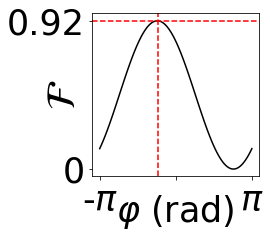

In [12]:
N = 3
philist = linspace(-pi,pi,100)
rhos = []
fids = []
for phi in philist:
    psi  = tensor(fock(N,0),fock(N,1))/sqrt(2) + exp(1j*phi)*tensor(fock(N,1),fock(N,0)/sqrt(2))
    rhoi = psi*psi.dag()
    rhos.append(Qobj(array(rhoi)))
    fids.append(abs(trace(dot(array(rhoi),rho_inv))))
    
fs = 35
fig = plt.figure(figsize = (3,3))
axins = fig.add_subplot(111)
# ax.plot(philist,np.sqrt(array(fids)))
axins.plot(philist,array(fids),'k-')
axins.set_ylabel('$\mathcal{F}$',fontsize = 40)
axins.yaxis.set_label_coords(-0.05,0.5)
axins.set_xlabel('$\\varphi$ (rad)',fontsize=fs)
axins.xaxis.set_label_coords(0.5,-0.1)
print ("phi = ",philist[argmax(fids)])
print("Fidelity = ",max((array(fids))))
axins.axvline(philist[argmax(fids)],color='r',ls = 'dashed')
axins.axhline(max(array(fids)),color='r',ls = 'dashed')
axins.set_xticks([-pi,0,pi])
axins.set_xticklabels(['-$\pi$','','$\pi$'],fontsize = fs)
axins.set_yticks([0,around(max(array(fids)),2)])
axins.set_yticklabels(['0','0.92'],fontsize = fs)

# plt.savefig("Supplement_Figures/2mode_angle_opt_resubmission.png", dpi = 400,bbox_inches='tight')

In [16]:
FOLDER_PATH = "collected_data\\Fig4\\"

expt_name = 'sequential_multimode_blockade_experiments_wt'
filenums = [42,41,43]

theta_pair_sets = []

show = 'I'

mode_state_num = 3
N = mode_state_num

for ff,filenum in enumerate(filenums):
    filename = FOLDER_PATH + str(filenum).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multimode_blockade_experiments_wt']
        qd_cfg = (json.loads(a.attrs['quantum_device_cfg']))
        tau = expt_cfg['ramsey_parity_time']
        chiges = array(qd_cfg['flux_pulse_info']['1']['chiby2pi_e'])
        parity_times = array(qd_cfg['flux_pulse_info']['1']['parity_time_e'])
        modes = expt_cfg['cavity_drive_mode_indices']
        thetas = [4*pi*abs(chiges)[mode]*(tau - parity_times[mode]) + pi for mode in modes]
        print ("Modes = ",modes)
        print ("Tomography angles = ",around(array(thetas),2))
        theta_pair_sets.append(thetas)

        Pss = array(a[show])
        Wss_1 =  -(4/pi**2)*(2*Pss-1)

#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        wigner_pts_file = FOLDER_PATH + "00001_wigner_points_nmax_4_nexpt_25_kappa_1pt5_t_300_ns_gauss_mode5.h5"
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y
        
        # Rotate all data by some amount
        betas = alphas[:len(Pss)]
        ROTATE_THETA = 0.729865
        alphas = alphas * np.exp(1j * ROTATE_THETA)

        alpha_2d = zeros((len(Pss[:]),len(alphas)),dtype = complex)
        print("number of Wigner points collected:", len(Pss))
        print("Wpts file name = ", expt_cfg['wigner_points_file_name'])
        print("Use transfer function = ",expt_cfg['transfer_fn_wt'])
        
        w = generalized_wigner_tomography_analysis_2m(alphas,betas,theta_pair_sets = [thetas],mode_state_num = N)
    
        for ii, Ps in enumerate(Pss[:]):
            alpha_2d[ii] = alphas
        
        if ff is 0:
            Wss = Wss_1
        else:
            Wss = append(Wss,Wss_1)
            
W_2m_data = Wss
w = generalized_wigner_tomography_analysis_2m(alphas,betas,theta_pair_sets = theta_pair_sets,mode_state_num = N) 

x_vec = W_2m_data.flatten()
rho_inv =  Qobj(w.rho_pinv_positive_sd(x_vec))
rho_inv_dat_2mode = rho_inv

Modes =  [3, 4]
Tomography angles =  [3.14 2.74]
number of Wigner points collected: 19
Wpts file name =  S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5
Use transfer function =  True
Modes =  [3, 4]
Tomography angles =  [3.39 2.94]
number of Wigner points collected: 19
Wpts file name =  S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5
Use transfer function =  True
Modes =  [3, 4]
Tomography angles =  [3.63 3.14]
number of Wigner points collected: 19
Wpts file name =  S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer/wigner_function_points/00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5
Use transfer function =  True


In [13]:
chis = array([-1.1962, -0.8676, -0.668 , -0.5679, -0.4677, -0.3718, -0.3588,-0.3127, -0.2714, -0.2758])
kappas  = array([18,9.02,5.23,4.19,3.24,1.4,1.48,0.72]) # kHz
T1s = array([2.022234293,2.1361789,2.049549382,1.88426546,1.790328021,1.842892764,2.00869047,1.938248911,1.997707949])*1e3

mode pair 3 4 : nud =  -2.0712 MHz, det of 2,0 and 0,2 -0.2003999999999999  MHz, omega =  0.20712000000000003  MHz
offset freqs: [-0.023300593798676106, -0.016081859415804756]
running mesolve for rotating frame
2500 500 1.0
500 2500 (1+0j)
500
157
time point 0
time point 100
time point 200
time point 300
time point 400
======================== fidelity vs phase of superposition =======================
147 17.675350701402806
[[ 7.19660733e-03+0.00000000e+00j  1.99343532e-02-2.85613771e-02j
   3.68591058e-03+2.77462789e-03j ...  1.93825591e-06-1.67651606e-06j
   7.82848920e-07-1.38888500e-06j  2.32983179e-07-4.63367291e-07j]
 [ 1.99343532e-02+2.85613771e-02j  4.54833700e-01+0.00000000e+00j
  -2.12085235e-03+6.02062167e-02j ...  3.04879198e-05+4.89996594e-06j
   1.94469296e-05-3.46637683e-06j  1.30039859e-05-3.00948605e-06j]
 [ 3.68591058e-03-2.77462789e-03j -2.12085235e-03-6.02062167e-02j
   8.27375081e-03+0.00000000e+00j ...  5.03070045e-07-4.06088005e-06j
  -5.46182450e-07-2.56345824e-

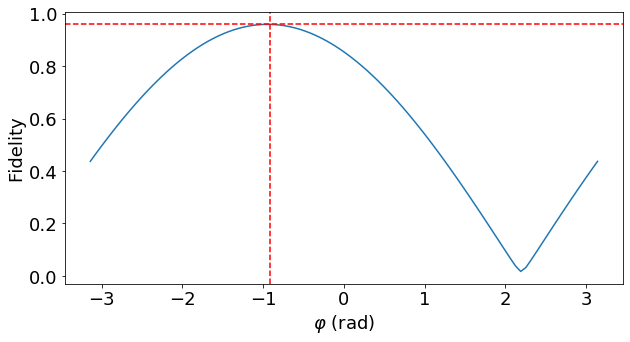

In [14]:
from numpy import exp

for ii in [3]:
    om = 0.107
    nu_d = 2*chis[ii] + 2*chis[ii+1] 
    diff =  (2*chis[ii] - 2*chis[ii+1] )
    
    offsets = []
    om = nu_d/10.0
    
    offsets.append(chis[ii] - sqrt(om**2 + chis[ii+1]**2) + sqrt(om**2 + (chis[ii+1]+chis[ii])**2) )
    offsets.append(chis[ii+1] - sqrt(om**2 + chis[ii]**2) + sqrt(om**2 + (chis[ii+1]+chis[ii])**2) )
    
#     for jj in range(ii,ii+2):
#         det1 = nu_d - 2*chis[jj]
#         det2 = nu_d 
#         offsets.append(-om**2/2/(det1**2) + om**2/2/(det2**2))
    
    print ("mode pair",ii,ii+1,": nud = ",nu_d,"MHz, det of 2,0 and 0,2",diff," MHz, omega = ",abs(om)," MHz")
    print ("offset freqs:",offsets)
    print ("================================================================================")
    

    blockade_params = {"chis":[chis[ii],chis[ii+1]],"kappas":[kappas[ii]*1e-3,kappas[ii+1]*1e-3], 
                       "blockade_frequencies":[2*chis[ii]+2*chis[ii+1]],
                       "blockade_rabi_rates":[om], "cavity_drive_offsets":[offsets[0],offsets[1]],
                       "cavity_epss":[1/4/25.0,1/4/25.0]}
    t1params = {"T1_ms":[1.85e3,2.1e3],"nth_ms":[0.0,0.0],"T1_q":80,"nth_q":0.01,"T2_q":60.0}
    exp_fid = multitone_multimode_blockade_experiment(transmon_levels = 2,mode_levels=5,
                                                  number_of_modes=2,hparams=blockade_params,
                                                  t1params = t1params,SAMPLE_RATE = 1)
    print("running mesolve for rotating frame")
        
    tlist_rot, out = exp_fid.qutip_mesolve(start_state = [1,0,0],tlist = linspace(0,60,500), get_dm=True)
    
print(len(out.expect), len(out.expect[0]), out.expect[0][0])
print(len(np.array(out.expect).T), len(np.array(out.expect).T[0]), np.array(out.expect).T[0][0])
print(len(tlist_rot))
best_index = int(18.9/60 * 500)
max_fids = []
print(best_index)
for index in range(500):
    if index%100 == 0:
        print("time point", index)
    rho_inv = np.reshape(np.array(out.expect).T[index], (50, 50))
#     rho_inv = np.reshape(np.array(out.expect).T[index], (18, 18))
    philist = linspace(-pi,pi,100)
    rhos = []
    fids = []
    for phi in philist:
        psi  = tensor(fock(2,0), tensor(fock(5,0),fock(5,1)))/sqrt(2) + \
                exp(1j*phi)*tensor(fock(2,0),tensor(fock(5,1),fock(5,0)/sqrt(2)))
#         psi  = tensor(fock(2,0), tensor(fock(3,0),fock(3,1)))/sqrt(2) + \
#                 exp(1j*phi)*tensor(fock(2,0),tensor(fock(3,1),fock(3,0)/sqrt(2)))
        rhoi = psi*psi.dag()
        rhos.append(Qobj(array(rhoi)))
        fids.append(abs(trace(dot(array(rhoi),rho_inv))))
    max_fids.append(np.max(fids))
    
print ("======================== fidelity vs phase of superposition =======================")
best_index = np.argmax(max_fids)
print(best_index, tlist_rot[best_index])
rho_inv = np.reshape(np.array(out.expect).T[best_index], (50, 50))
rho_2mode_sim = rho_inv
# rho_inv = np.reshape(np.array(out.expect).T[best_index], (18, 18))
print(rho_inv)
philist = linspace(-pi,pi,100)
rhos = []
fids = []
for phi in philist:
    psi  = tensor(fock(2,0), tensor(fock(5,0),fock(5,1)))/sqrt(2) + \
            exp(1j*phi)*tensor(fock(2,0),tensor(fock(5,1),fock(5,0)/sqrt(2)))
#     psi  = tensor(fock(2,0), tensor(fock(3,0),fock(3,1)))/sqrt(2) + \
#         exp(1j*phi)*tensor(fock(2,0),tensor(fock(3,1),fock(3,0)/sqrt(2)))
    rhoi = psi*psi.dag()
    rhos.append(Qobj(array(rhoi)))
    fids.append(abs(trace(dot(array(rhoi),rho_inv))))
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.plot(philist,np.sqrt(array(fids)))
ax.set_ylabel('Fidelity')
ax.set_xlabel('$\\varphi$ (rad)')
print ("phi = ",philist[argmax(fids)])
print("Fidelity = ",max(np.sqrt(array(fids))))
axvline(philist[argmax(fids)],color='r',ls = 'dashed')
axhline(max(np.sqrt(array(fids))),color='r',ls = 'dashed')
plt.show()

81
[[ 7.19660733e-03+0.00000000e+00j -3.05442103e-02+1.67386354e-02j
   3.68591058e-03+2.77462789e-03j -3.15406491e-02+1.65956937e-02j
  -1.38270469e-05+1.95361538e-03j  4.41426469e-04+7.13347954e-05j
   8.04398074e-04-3.70051140e-04j  1.52901139e-05+2.55342519e-05j
   6.14163607e-05-2.78701039e-05j]
 [-3.05442103e-02-1.67386354e-02j  4.54833700e-01+0.00000000e+00j
  -2.48353002e-02-5.48861950e-02j  4.59487408e-01+1.15222746e-02j
   1.27265556e-02-2.18263262e-02j -4.56884807e-03-3.69766755e-03j
  -1.15675039e-02-7.81436685e-04j  1.56005211e-05-3.27221189e-04j
  -8.77281185e-04-1.05768077e-04j]
 [ 3.68591058e-03-2.77462789e-03j -2.48353002e-02+5.48861950e-02j
   8.27375081e-03+0.00000000e+00j -2.64873619e-02+5.48538800e-02j
   1.87527883e-03+2.76997878e-03j  6.99566760e-04-3.47604858e-04j
   7.14153604e-04-1.35687038e-03j  3.92236826e-05+2.15111731e-05j
   6.16310654e-05-1.00169930e-04j]
 [-3.15406491e-02-1.65956937e-02j  4.59487408e-01-1.15222746e-02j
  -2.64873619e-02-5.48538800e-02j 

[Text(0, 0, '0'), Text(0, 0, '0.25'), Text(0, 0, '0.5')]

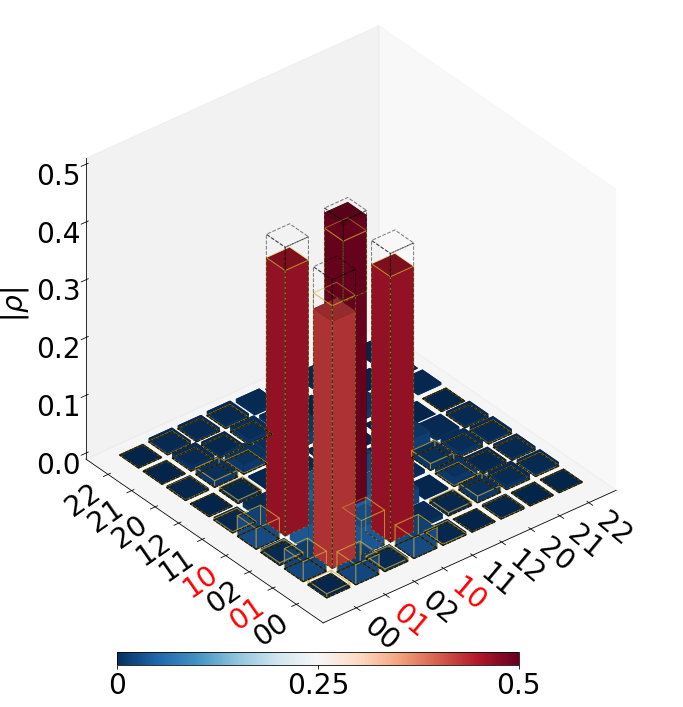

In [22]:
matplotlib.rcParams.update({'font.size': 28})
from matplotlib.transforms import Affine2D

rho_ideal_2mode = np.zeros((N**2, N**2))
rho_ideal_2mode[1][1] = 0.5
rho_ideal_2mode[N][1] = 0.5
rho_ideal_2mode[1][N] = 0.5
rho_ideal_2mode[N][N] = 0.5
rho_ideal_2mode = rho_ideal_2mode.ravel()
print(len(rho_ideal_2mode))

rho_sim_2mode = np.zeros((N**2, N**2), dtype=complex)
for i in range(N):
    for j in range(N):
        rho_sim_2mode[i*N:(i+1)*N, j*N:(j+1)*N] = rho_2mode_sim[i*5:i*5+N, j*5:j*5+N]

phi_rot = -0.9202645146879189/2
# phi_rot= np.pi
# phi_rot = 0
# rot_mat = np.identity(N**2)
# rot_mat[1][N] = np.sin(phi_rot)
# rot_mat[N][1] = -np.sin(phi_rot)
# rot_mat[1][1] = np.cos(phi_rot)
# rot_mat[N][N] = np.cos(phi_rot)
# rot_matH = np.identity(N**2)
# rot_matH[1][N] = -np.sin(phi_rot)
# rot_matH[N][1] = np.sin(phi_rot)
# rot_matH[1][1] = np.cos(phi_rot)
# rot_matH[N][N] = np.cos(phi_rot)
# print(np.dot(rot_mat, rot_matH))

# rho_sim_2mode = np.dot(rot_mat, np.dot(rho_sim_2mode, rot_matH)) / np.exp(1j * phi_rot/2)
# print(np.dot(rot_mat, [[0j], [1], [0], [1], [0], [0], [0], [0], [0]]))
# rho_sim_2mode[:, N] *= np.exp(1j * phi_rot)
# rho_sim_2mode[N] *= np.exp(-1j * phi_rot)
rho_sim_2mode[:, 1] *= np.exp(-1j * phi_rot) * -1
rho_sim_2mode[1] *= np.exp(1j * phi_rot) * -1
rho_sim_2mode[:, N] *= -1 * np.exp(1j * phi_rot)
rho_sim_2mode[N] *= -1 * np.exp(-1j * phi_rot)
print(rho_sim_2mode)

rho_sim_2mode = rho_sim_2mode.ravel()
# rho_2mode_sim obtained from running 2 mode simulation in section for SFig. 13/14, which was run with 5 mode levels
# above matrix construction currently coded with N = 3 in mind, simulated 5 levels in mind

eps = 0
print ("=================== Density matrix obtained from inverting real data ======================")
print ("TRACE OF RHO FROM REAL DATA = ",eps,':',trace(rho_inv))

fig = plt.figure(figsize=(12, 12))
mode_level = 3
rho_inv2 = zeros((N**2,N**2),dtype=complex)
rho_inv2[:N**2,:N**2] = rho_inv_dat_2mode


azim_angle = 231
padamnt = 25
elevation = 35

ax = fig.add_subplot(111, projection='3d', azim=azim_angle, elev=elevation, proj_type='ortho')
_x = np.arange(N**2) - 0.5
_y = np.arange(N**2) - 0.5
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
rho_inv2 = rho_inv2.ravel()

cmap = cm.get_cmap("RdBu_r")
bottoms = np.minimum(np.zeros_like(real(array(rho_inv2))), real(array(rho_inv2)))
tops = np.maximum(np.zeros_like(real(array(rho_inv2))), real(array(rho_inv2)))
# colors = [cmap((real(piece) + 1)/2) for piece in rho_inv2]
colors = [cmap(2*abs(piece)) for piece in rho_inv2]
rho_inv2 = np.absolute(rho_inv2)

# print(tops)
# print(bottoms)

square_size = 0.8

c = ax.bar3d(x,y,np.zeros_like(np.absolute(rho_inv2)), square_size, square_size, np.absolute(rho_inv2), cmap='RdBu_r',
              color=colors, alpha=1, zorder=np.absolute(rho_inv2))

debug_len = 81
exclude_indices = [13,19,20,21,22,23,29,31,32,37,38,39,40,41,42,43,47,48,49,50,51,52,57,58,59,60,61,62,67,68,69,70,71,
                  76,77,78,79,80]
use_indices = []
for i in range(N**4):
    if i not in exclude_indices:
        use_indices.append(i)
        
edges_ideal = [(0,0,0,0.5) for i in range(len(use_indices) * 6)]
edges_sim = [(212/256, 175/256, 55/256, 0.5) for i in range(len(use_indices) * 6)]
cut_indices = [60,63,65, 66,69,70, 72,75,77, 
               132,135,137, 138,141,143]
cut_indices2 = np.append(cut_indices, [67])
for index in range(len(use_indices)*6):
    if index >= 480 or index in cut_indices:
        edges_ideal[index] = (0,0,1,0)
        edges_sim[index] = (0,0,1,0)
    if index in cut_indices2:
        edges_ideal[index] = (0,0,1,0)

shift1 = 0.36
rho_ideal_2mode_base = np.zeros_like(array(rho_ideal_2mode))
rho_sim_2mode_base = np.zeros_like(array(rho_ideal_2mode))
rho_ideal_2mode_base[30] = shift1
rho_ideal_2mode[30] -= shift1
rho_sim_2mode_base[30] = shift1
rho_sim_2mode[30] -= shift1
    
csim = ax.bar3d(x[use_indices],y[use_indices], rho_sim_2mode_base[use_indices], square_size, square_size, 
                abs(rho_sim_2mode)[use_indices], color=(212/256, 175/256, 55/256, 0.0), 
                edgecolor=edges_sim)
cideal = ax.bar3d(x[use_indices],y[use_indices], rho_ideal_2mode_base[use_indices], 
                  square_size, square_size, abs(rho_ideal_2mode)[use_indices], 
                  color=(0,0,0,0), linestyle='dashed', edgecolor=edges_ideal)

c = ax.bar3d(x,y,np.zeros_like(array(rho_inv2)), square_size, square_size, abs(array(rho_inv2)), cmap='RdBu_r',
              color=colors, alpha=1, zorder=abs(array(rho_inv2)))
c.set_alpha(1)
c.set_array(np.array([]))

# cax = ax.bar3d(x,y,bottoms, 1, 1, tops, cmap='RdBu_r',
#               color=colors)
# xticks(arange(N**2),[str(int(i/mode_level))+str(int(i%mode_level)) for i in arange(N**2) ])
xticks(arange(N**2),[str(int(i/mode_level))+str(int(i%mode_level)) for i in arange(N**2)])
yticks(arange(N**2),[str(int(i/mode_level))+str(int(i%mode_level)) for i in arange(N**2)])
# ax.set_xlabel('$\\left|m\\right>$')
# ax.set_xlabel('$\\left|m\\right>$', labelpad=padamnt)
# ax.set_ylabel('$\\left|n\\right>$', labelpad=padamnt)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('$|\\rho|$', labelpad=padamnt, rotation=90)
ax.set_zlim([0.0, 0.5])
ax.set_zticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='y', which='major', pad=-5)
yticks(rotation=35, ha='right')
ax.tick_params(axis='x', which='major', pad=-5)
xticks(rotation=-40, ha='left')

plt.gca().get_xticklabels()[1].set_color('red')
# plt.gca().spines.set_color('red')
plt.gca().get_xticklabels()[3].set_color('red')
plt.gca().get_yticklabels()[1].set_color('red')
plt.gca().get_yticklabels()[3].set_color('red')

ax.grid(False)
# ax.zaxis._axinfo['label']['space_factor'] = 2.8

# axins2 = inset_axes(ax, width="2%", height="50%", loc='lower right',
#                    bbox_to_anchor=(-0.5,0.2, 1.5,1.0), bbox_transform=ax.transAxes)
# cbar = colorbar(c, cax=axins2, cmap='RdBu_r', ticks=[0, 0.5, 1.0])
# cbar.ax.set_yticklabels(['0', '0.25', '0.5'])

axins2 = inset_axes(ax, width="40%", height="2%", loc='lower right',
                   bbox_to_anchor=(-0.715,-0.03, 1.5,1.0), bbox_transform=ax.transAxes)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# test = matplotlib.cm.ScalarMappable(norm=norm, cmap='RdBu_r')
# test.set_array(np.array([]))
cbar = colorbar(c, cax=axins2, ticks=[0, 0.5, 1.0], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '0.25', '0.5'])

# axins3 = inset_axes(ax, width="12%", height="15%", loc='upper left',
#                    bbox_to_anchor=(0.2,-0.22, 1.5,1.0), bbox_transform=ax.transAxes)
# # axins3 = inset_axes(ax, width="15%", height="15%", loc='upper left',
# #                    bbox_to_anchor=(0.2,-0.22, 1.5,1.0), bbox_transform=ax.transAxes + Affine2D().rotate(np.pi/5))
# axins3.set_xlabel("$\\phi$")
# axins3.set_ylabel("Fidelity")


# cbar = fig.colorbar(cax, ticks=[0,0.5, 1])
# cbar.ax.set_yticklabels(['0','0.5', '1'])

# ax = fig.add_subplot(122, projection='3d', azim=azim_angle, elev=elevation)
# cmap = cm.get_cmap("RdBu_r")
# bottoms = np.minimum(np.zeros_like(imag(array(rho_inv2))), imag(array(rho_inv2)))
# tops = np.maximum(np.zeros_like(imag(array(rho_inv2))), imag(array(rho_inv2)))
# colors = [cmap((imag(piece) + 1)/2) for piece in rho_inv2]
# cax = ax.bar3d(x,y,np.zeros_like(imag(array(rho_inv2))), 1, 1, imag(array(rho_inv2)), color=colors)
# # cax = ax.bar3d(x,y,bottoms, 1, 1, tops, color=colors)
# xticks(arange(N**2),[str(int(i/mode_level))+str(int(i%mode_level)) for i in arange(N**2)])
# yticks(arange(N**2),[str(int(i/mode_level))+str(int(i%mode_level)) for i in arange(N**2)])
# ax.set_xlabel('$\\left|m\\right>$', labelpad=padamnt)
# ax.set_ylabel('$\\left|n\\right>$', labelpad=padamnt)
# ax.zaxis.set_rotate_label(False)  # disable automatic rotation
# ax.set_zlabel('Im[$\\rho$]', labelpad=padamnt, rotation=90, fontsize=20)
# ax.set_zlim([-0.05, 0.5])
# ax.set_zticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
# ax.grid(False)
# cbar = fig.colorbar(cax, ticks=[-1,-0.5,0,0.5, 1])
# cbar.ax.set_yticklabels([' -1','-0.5',' 0','0.5', ' 1'])

# plt.savefig("Supplement_Figures/2mode_dm_3D_all_real_horizontal_cbar_resubmission.pdf", dpi = 400,bbox_inches='tight') 

## 3 mode

In [ ]:
FOLDER_PATH = "collected_data\\Fig4\\"

N = 3
mode_state_num = N
num_modes = 3
eps = 0

from numpy import exp
from itertools import product


expt_name = 'sequential_multimode_blockade_experiments_wt_3modes'
filenums = [3,4]

for ii,filenum in enumerate(filenums):

    show = 'I'
    filename = FOLDER_PATH + str(filenum).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multimode_blockade_experiments_wt']
        qd_cfg = (json.loads(a.attrs['quantum_device_cfg']))
        tau = expt_cfg['ramsey_parity_time']
        chiges = array(qd_cfg['flux_pulse_info']['1']['chiby2pi_e'])
        parity_times = array(qd_cfg['flux_pulse_info']['1']['parity_time_e'])
        modes = expt_cfg['cavity_drive_mode_indices']
        thetas = [4*pi*abs(chiges)[mode]*(tau - parity_times[mode]) + pi for mode in modes]
        print(expt_cfg['cavity_pulse_len'])
        print ("Modes = ",modes)
        print ("Tomography angles = ",around(array(thetas),2))

        Pss = array(a[show])
        Wss_t =  -(2/pi)**3*(2*Pss-1)
        
        if ii is 0: Wss = Wss_t
        else: Wss = concatenate((Wss,Wss_t),axis=0)

#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        wigner_pts_fiLe = FOLDER_PATH + "00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5"
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y

print ("Final data shape = ", shape(Wss))
print ("REAL DATA")
W_3m_data = Wss
x_vec = W_3m_data.flatten()

rotate_alpha_angles = [0, -0.4027682889217683, -0.8860902356278904]
# rotate_alpha_angles = [0,0,0]
w = generalized_wigner_tomography_nmodes(alphas,theta_sets = [thetas],
                                         number_of_modes=num_modes, mode_state_num=N,
                                         rotate_alpha_angles=rotate_alpha_angles)

rho_inv_exp =  w.rho_pinv_positive_sd(x_vec)

In [ ]:
rho_3mode_no_rot = rho_inv_exp

In [ ]:
N = 3
philist = linspace(-pi,pi,40)
rhos = []
fids = zeros((len(philist),len(philist)))
phislist = []
fidslist = []
for jj,phi2 in enumerate(philist):
    for ii,phi1 in enumerate(philist):
        psi  = (tensor(fock(N,0),fock(N,0),fock(N,1))/sqrt(3) + exp(1j*phi1)*tensor(fock(N,0),fock(N,1),fock(N,0))/sqrt(3)\
                + exp(1j*phi2)*tensor(fock(N,1),fock(N,0),fock(N,0))/sqrt(3))

        rhoi = psi*psi.dag()
        fid = abs(trace(dot(array(rhoi),rho_3mode_no_rot)))
        fids[jj][ii] = fid
        fidslist.append(fid)
        phislist.append(phi1+1j*phi2)
    

fs = 30
fig = plt.figure(figsize = (3.5,3.5))
axins = fig.add_subplot(111)

print ("Fidelity = ",max(fidslist))
cax2 = axins.pcolormesh(philist,philist,fids,cmap = 'Blues',vmax =max(fidslist),vmin=0 )
phi1,phi2 = real(phislist[argmax(fidslist)]),imag(phislist[argmax(fidslist)])
axins.axvline(phi1,color='g',ls='dashed')
axins.axhline(phi2,color='g',ls='dashed')
print ("phi_1, phi_2 = ",phi1,phi2)

# cbar2 = fig.colorbar(cax2,shrink=0.25, ticks=[-1,0,1],pad=+0.025,location='bottom')
axins.set_ylabel('$\\varphi_2$ (rad)',fontsize = fs)
axins.set_xlabel('$\\varphi_1$ (rad)',fontsize = fs)
axins.set_xticks([-pi,pi])
axins.set_xticklabels(['-$\pi$','$\pi$'],fontsize = fs)
axins.xaxis.set_label_coords(0.5,-0.05)
axins.yaxis.set_label_coords(-0.05,0.5)
axins.set_yticks([-pi,pi])
axins.set_yticklabels(['-$\pi$','$\pi$'],fontsize = fs)
axins2 = inset_axes(axins,
                   width="6%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axins.transAxes,
                   borderpad=0,
                   )
cbar2 = fig.colorbar(cax2, cax=axins2, ticks=[0,max(fidslist)])
cbar2.ax.set_yticklabels(['0',' 0.87'],fontsize = fs)
# cbar2.set_label('$\mathcal{F}$',labelpad=-2)
axin3 = cbar2.ax
axin3.text(2,0.3,'$\mathcal{F}$',rotation=0, fontsize=40)

# plt.savefig("Supplement_Figures/3mode_angle_opt_resubmission.png", dpi = 400,bbox_inches='tight')

In [ ]:
from numpy import exp

ii = 2
jj = 3
kk = 4


nu_d = (4*chis[ii] + 4*chis[jj] + 4*chis[kk])/3.0

delta_ii = (-2*chis[ii] + 4*chis[jj] + 4*chis[kk])/3.0
delta_jj = (4*chis[ii] -2*chis[jj] + 4*chis[kk])/3.0
delta_kk = (4*chis[ii] +4*chis[jj] -2*chis[kk])/3.0


offsets = []
om = nu_d/10.0

offsets.append(-sqrt(om**2 + (delta_ii /2.0)**2) + abs(delta_ii/2.0) +sqrt(om**2 + (nu_d/2.0)**2) - abs(nu_d/2.0))
offsets.append(-sqrt(om**2 + (delta_jj /2.0)**2) + abs(delta_jj/2.0) +sqrt(om**2 + (nu_d/2.0)**2) - abs(nu_d/2.0))
offsets.append(-sqrt(om**2 + (delta_kk /2.0)**2) + abs(delta_kk/2.0) +sqrt(om**2 + (nu_d/2.0)**2) - abs(nu_d/2.0))


print ("mode triplet",ii,jj,kk,": nud = ",nu_d,"MHz,  omega = ",abs(om)," MHz")
print ("offset freqs:",offsets)
print ("================================================================================")

blockade_params = {"chis":[chis[ii],chis[jj],chis[kk]],"kappas":[kappas[ii]*1e-3,kappas[jj]*1e-3,kappas[kk]*1e-3], 
                   "blockade_frequencies":[nu_d], "blockade_rabi_rates":[om], 
                   "cavity_drive_offsets":offsets,"cavity_epss":[1/4/25.0,1/4/25.0,1/4/25.0]}
t1params = {"T1_ms":[T1s[ii],T1s[jj],T1s[kk]],"nth_ms":[0.0,0.0,0.0],"T1_q":80,"nth_q":0.01,"T2_q":60.0}
sim2 = multitone_multimode_blockade_experiment(transmon_levels = 2,mode_levels=5,number_of_modes=3,
                                               hparams=blockade_params,t1params = t1params,SAMPLE_RATE = 1)
tlist_rot, out = sim2.plot_mesolve(start_state = [1,0,0],tlist = linspace(0,60,500), get_dm=True)

In [ ]:
N = 5
max_fids = []

for index in range(200):  # W state before this number of indices
    if index%20 == 0:
        print("time point", index)
    rho_inv_exp = np.reshape(np.array(out.expect).T[index], (250, 250))
    rhos = []
    fids = zeros((len(philist),len(philist)))
    phislist = []
    fidslist = []
    for jj,phi2 in enumerate(philist):
        for ii,phi1 in enumerate(philist):
            psi = tensor(fock(2, 0), fock(N,0),fock(N,0),fock(N,1))/sqrt(3) + \
                  exp(1j*phi1)*tensor(fock(2,0), fock(N,0),fock(N,1),fock(N,0))/sqrt(3) + \
                  exp(1j*phi2)*tensor(fock(2,0), fock(N,1),fock(N,0),fock(N,0))/sqrt(3)
            rhoi = psi*psi.dag()
            fid = abs(trace(dot(array(rhoi),rho_inv_exp)))
            fids[jj][ii] = fid
            fidslist.append(fid)
            phislist.append(phi1+1j*phi2)
    max_fids.append(np.max(fidslist))

best_index = np.argmax(max_fids)
print(best_index, tlist_rot[best_index])
rho_inv = np.reshape(np.array(out.expect).T[best_index], (250, 250))
print(rho_inv)

rho_3mode_sim = rho_inv

philist = linspace(-pi,pi,40)
rhos = []
fids = zeros((len(philist),len(philist)))
phislist = []
fidslist = []
for jj,phi2 in enumerate(philist):
    for ii,phi1 in enumerate(philist):
        psi = tensor(fock(2, 0), fock(N,0),fock(N,0),fock(N,1))/sqrt(3) + \
              exp(1j*phi1)*tensor(fock(2,0), fock(N,0),fock(N,1),fock(N,0))/sqrt(3) + \
              exp(1j*phi2)*tensor(fock(2,0), fock(N,1),fock(N,0),fock(N,0))/sqrt(3)
        rhoi = psi*psi.dag()
        fid = abs(trace(dot(array(rhoi),rho_inv)))
        fids[jj][ii] = fid
        fidslist.append(fid)
        phislist.append(phi1+1j*phi2)

        
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)

pcolormesh(philist,philist,fids,cmap = 'RdBu_r',vmin=0.0, vmax=1.0)
clim(0, 1)
print ("Fidelity = ",sqrt(max(fidslist)))
print("Fidelity without sqrt = ", max(fidslist))
phi1,phi2 = real(phislist[argmax(fidslist)]),imag(phislist[argmax(fidslist)])
axvline(phi1,color='g',ls='dashed')
axhline(phi2,color='g',ls='dashed')
print ("phi_1, phi_2 = ",phi1,phi2)
ax.set_ylabel('$\\varphi_2$ (rad)')
ax.set_xlabel('$\\varphi_1$ (rad)')
ax.set_xticks([-3,-2,-1,0,1,2,3])
ticklist = [0.0,0.25,0.5,0.75,1.0]

colorbar()

In [ ]:
FOLDER_PATH = "collected_data\\Fig4\\"

N = 3
mode_state_num = N
num_modes = 3
eps = 0

from numpy import exp


expt_name = 'sequential_multimode_blockade_experiments_wt_3modes'
filenums = [3,4]

for ii,filenum in enumerate(filenums):

    show = 'I'
    filename = "S:/_Data/200302 - 3DMM2 cooldown 10 - sideband with LO and mixer" + \
                "\\data\\" + str(filenum).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['multimode_blockade_experiments_wt']
        qd_cfg = (json.loads(a.attrs['quantum_device_cfg']))
        tau = expt_cfg['ramsey_parity_time']
        chiges = array(qd_cfg['flux_pulse_info']['1']['chiby2pi_e'])
        parity_times = array(qd_cfg['flux_pulse_info']['1']['parity_time_e'])
        modes = expt_cfg['cavity_drive_mode_indices']
        thetas = [4*pi*abs(chiges)[mode]*(tau - parity_times[mode]) + pi for mode in modes]
        print(expt_cfg['cavity_pulse_len'])
        print ("Modes = ",modes)
        print ("Tomography angles = ",around(array(thetas),2))

        Pss = array(a[show])
        Wss_t =  -(2/pi)**3*(2*Pss-1)
        
        if ii is 0: Wss = Wss_t
        else: Wss = concatenate((Wss,Wss_t),axis=0)

#         wigner_pts_file = expt_cfg['wigner_points_file_name']
        wigner_pts_file = FOLDER_PATH + "00001_wigner_points_nmax_3_nexpt_18_kappa_1pt1_t_300_ns_gauss_mode5.h5"
        with File(wigner_pts_file,'r') as b:
            x = array(b['alphax'])
            y = array(b['alphay'])
            alphas =x+1j*y

print ("Final data shape = ", shape(Wss))
print ("REAL DATA")
W_3m_data = Wss
x_vec = W_3m_data.flatten()

rotate_alpha_angles = [0, -0.4027682889217683, -0.8860902356278904]
# rotate_alpha_angles = [0,0,0]
w = generalized_wigner_tomography_nmodes(alphas,theta_sets = [thetas],
                                         number_of_modes=num_modes, mode_state_num=N,
                                         rotate_alpha_angles=rotate_alpha_angles)

rho_inv_exp =  w.rho_pinv_positive_sd(x_vec)

In [ ]:
import matplotlib.transforms


N = 3
rho_ideal_3mode = np.zeros((N**3, N**3))
rho_ideal_3mode[1][1] = 1/3
rho_ideal_3mode[1][N] = 1/3
rho_ideal_3mode[1][N**2] = 1/3
rho_ideal_3mode[N][1] = 1/3
rho_ideal_3mode[N][N] = 1/3
rho_ideal_3mode[N][N**2] = 1/3
rho_ideal_3mode[N**2][1] = 1/3
rho_ideal_3mode[N**2][N] = 1/3
rho_ideal_3mode[N**2][N**2] = 1/3
rho_ideal_3mode = rho_ideal_3mode.ravel()

# rho_3mode_sim from "3 Mode Simulations" section
rho_sim_3mode = np.zeros((N**3, N**3), dtype=complex)
for i in range(N):
    for j in range(N):
        for k in range(N):
            for m in range(N):
                rho_sim_3mode[i*N+k*N**2:(i+1)*N+k*N**2, j*N+m*N**2:(j+1)*N+m*N**2] = \
                rho_3mode_sim[i*5+k*5**2:i*5+N+k*5**2, j*5+m*5**2:j*5+N+m*5**2]

# phi1_rot = -0.4027682889217683
# phi2_rot = -0.8860902356278904
# rho_sim_3mode[:, 1] *= np.exp(-1j * phi_rot) * -1
# rho_sim_3mode[1] *= np.exp(1j * phi_rot) * -1
# rho_sim_3mode[:, N] *= -1 * np.exp(1j * phi_rot)
# rho_sim_3mode[N] *= -1 * np.exp(-1j * phi_rot)
                
rho_sim_3mode = rho_sim_3mode.ravel()
print(len(rho_3mode_sim))

print ("=================== Density matrix obtained from inverting ideal data @ wpts ======================")
print ("TRACE WITH NOISE EPS = ",eps,':',trace(rho_inv))



fig = plt.figure(figsize=(12,12))

state_tick_list = ['$\\left|' + str(int(i/mode_state_num**2))+str(int(i/mode_state_num)%mode_state_num) \
                     + str(i%mode_state_num) + '\\right>$' for i in arange(N**3)]
state_tick_list = [str(int(i/mode_state_num**2))+str(int(i/mode_state_num)%mode_state_num) \
                     + str(i%mode_state_num) for i in arange(N**3)]
for index in range(len(state_tick_list)//2 + 1):
    state_tick_list[2*index] = ''

azim_angle = 231
elevation = 35
print(N)
_x = np.arange(N**3) - 1
_y = np.arange(N**3) - 1
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
# print(rho_inv_exp)
rho_inv_exp = rho_inv_exp.ravel()
print(len(rho_inv_exp), len(x), len(y))

ax = fig.add_subplot(111, projection='3d', azim=azim_angle, elev=elevation, proj_type='ortho')
cmap = cm.get_cmap("RdBu_r")
colors = [cmap(abs(piece)*2.5) for piece in rho_inv_exp]

skip_list = [[] for i in range(N**3)]
skip_list[1] = [2,10]
skip_list[2] = [1,2,3,4,5,9,10,11]
skip_list[3] = [2,4,5,6,10,11,12]
skip_list[4] = [1,2,3,4,5,6,10,11,12]
skip_list[5] = [1,2,3,4,5,6,7,9,10,11,12,13]
skip_list[6] = [2,3,4,5,6,7,8,10,11,12,13,14]
skip_list[7] = [3,4,5,6,7,8,9,11,12,13,14,15]
skip_list[8] = [4,5,6,7,8,9,10,12,13,14,15,16]
skip_list[9] = [2,5,6,7,8,10,13,14,15,16,17]
skip_list[10] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
skip_list[11] = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
skip_list[12] = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
skip_list[13] = [3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20]
skip_list[14] = [4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]
skip_list[15] = [5,6,7,8,9,10,11,12,13,14,15,18,19,20,21,22]
skip_list[16] = [6,7,8,9,10,11,12,13,14,15,16,19,20,21,22]
skip_list[17] = [6,7,8,9,10,11,12,13,14,15,16,17,20,21,22,23]
skip_list[18] = [7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,24]
skip_list[19] = [8,9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25]
skip_list[20] = [9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26]
skip_list[21] = [9,10,11,12,13,14,15,16,17,18,19,23,24,25,26]
skip_list[22] = [10,11,12,13,14,15,16,17,18,19,20,24,25,26]
skip_list[23] = [11,12,13,14,15,16,17,18,19,20,21,25,26]
skip_list[24] = [12,13,14,15,16,19,20,21,22,26]
skip_list[25] = [12,13,14,15,16,20,21,22,23,26]
skip_list[26] = [13,14,15,16,17,20,21,22,23,24]

for k in range(N**3)[27:]:
    skip_list[k] = np.arange(27)

use_indices = []
for i in range(N**3):
    for j in range(N**3):
        if j not in skip_list[i]:
            use_indices.append(N**3 * i + j)

edges_ideal = [(0,0,0,0.5) for i in range(len(use_indices) * 6)]
edges_sim = [(212/256, 175/256, 55/256, 0.5) for i in range(len(use_indices) * 6)]
cut_indices = [168,171,173, 174,177,179, 180,181,183,184,185, 210,213,215,
              432,435,437, 438,441,443, 456,459,461,
              553,554,555,556,557,558, 564,565,566,569,
              1020,1023,1025, 1026,1029,1031, 1032,1035,1036,1037, 1038,1041,1043]
cut_indices2 = np.append(cut_indices, [1039,567,568,1033])
for index in range(len(use_indices)*6):
    if index >= 2500 or index in cut_indices:
        edges_ideal[index] = (0,0,1,0)
        edges_sim[index] = (0,0,1,0)
    if index in cut_indices2:
        edges_ideal[index] = (0,0,1,0)

        
fs = 34
fs_xy = 30
padamnt = 32
square_size = 0.7

shift1 = 0.178
rho_ideal_3mode_base = np.zeros_like(array(rho_ideal_3mode))
rho_sim_3mode_base = np.zeros_like(array(rho_ideal_3mode))
rho_ideal_3mode_base[84] = shift1
rho_ideal_3mode[84] -= shift1
rho_sim_3mode_base[84] = shift1
rho_sim_3mode[84] -= shift1
shift1 = 0.151
rho_ideal_3mode_base[252] = shift1
rho_ideal_3mode[252] -= shift1
rho_sim_3mode_base[252] = shift1
rho_sim_3mode[252] -= shift1
rho_ideal_3mode_base = rho_ideal_3mode_base[use_indices]
rho_sim_3mode_base = rho_sim_3mode_base[use_indices]

cdat = ax.bar3d(x,y,np.zeros_like(array(rho_inv_exp)), square_size, square_size, abs(array(rho_inv_exp)), cmap='RdBu_r',
              color=colors, alpha=1)
c_ideal3 = ax.bar3d(x[use_indices], y[use_indices], rho_ideal_3mode_base, 
                    square_size, square_size, np.abs(array(rho_ideal_3mode)[use_indices]),
                    color=(0,0,1,0), edgecolor=edges_ideal, 
                    linestyle='dashed')
# c_ideal3 = ax.bar3d(x[use_indices], y[use_indices], abs(array(rho_inv_exp))[use_indices], 
#                     square_size, square_size, np.abs(array(rho_ideal_3mode)[use_indices]) -
#                     np.abs(array(rho_inv_exp))[use_indices],
#                     color=(0,0,1,0), edgecolor=(0,0,0,0.5), 
#                     linestyle='dashed')
c_sim3 = ax.bar3d(x[use_indices], y[use_indices], rho_sim_3mode_base, 
                  square_size, square_size, abs(array(rho_sim_3mode)[use_indices]),
                  color=(0,0,1,0), edgecolor=edges_sim)
cdat = ax.bar3d(x,y,np.zeros_like(array(rho_inv_exp)), square_size, square_size, abs(array(rho_inv_exp)), cmap='RdBu_r',
              color=colors, alpha=1)

offset = 0
xticks(arange(N**3)-(1-square_size)/2, state_tick_list, rotation=-40, ha='left', va='top', 
       transform=offset, fontsize=fs_xy)
yticks(arange(N**3)-(1-square_size)/2, state_tick_list, rotation=55, ha='right', fontsize=fs_xy)

ax.tick_params(axis='x', pad=-8)
ax.tick_params(axis='y', pad=-8)

# xticks(arange(N**3),state_tick_list)
# yticks(arange(N**3),state_tick_list)
# ax.grid(True,alpha = 0.5,ls='dashed')
ax.grid(False)
# ax.set_xlabel('$\\left|m\\right>$', labelpad=padamnt)
# ax.set_ylabel('$\\left|n\\right>$', labelpad=padamnt)
ax.set_zlim([0.0, 0.4])
ax.set_zticks([0.0, 0.1, 0.2, 0.3, 0.4])
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(fs)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('$|\\rho|$', labelpad=padamnt, rotation=90, fontsize=fs)
ax.tick_params(axis='z', which='major', pad=13)

plt.gca().get_xticklabels()[1].set_color('red')
plt.gca().get_xticklabels()[3].set_color('red')
plt.gca().get_xticklabels()[9].set_color('red')
plt.gca().get_yticklabels()[1].set_color('red')
plt.gca().get_yticklabels()[3].set_color('red')
plt.gca().get_yticklabels()[9].set_color('red')

# from matplotlib.transforms import *
# test_transform = BboxTransformTo(
#     TransformedBbox(
#         Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.88),
#         BboxTransformTo(
#             TransformedBbox(
#                 Bbox(x0=0.0, y0=0.0, x1=12.0, y1=12.0),
#                 Affine2D(
#                     [[72.,  0.,  0.],
#                      [ 0., 72.,  0.],
#                      [ 0.,  0.,  1.]])))))

# axins2 = inset_axes(ax, width="2%", height="50%", loc='lower right',
#                    bbox_to_anchor=(-0.5,0.2, 1.5,1.0), bbox_transform=ax.transAxes)
# # axins2 = inset_axes(ax, width="2%", height="30%", loc='lower right',
# #                    bbox_to_anchor=(-0.7,0.5, 1.5,1.0), bbox_transform=ax.transAxes)
# cbar = fig.colorbar(cdat, cax=axins2, ticks=[0, 0.5, 1.0])
# # cbar = fig.colorbar(cdat, cax=ax)
# cbar.ax.set_yticklabels(['0', '0.2', '0.4'])

axins2 = inset_axes(ax, width="40%", height="2%", loc='lower right',
                   bbox_to_anchor=(-0.715,-0.025, 1.5,1.0), bbox_transform=ax.transAxes)
cbar = colorbar(cdat, cax=axins2, cmap='RdBu_r', ticks=[0, 0.5, 1.0], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '0.2', '0.4'], fontsize=fs)


# cbar = fig.colorbar(cax, ticks=[-1,-0.5,0,0.5, 1])
# cbar.ax.set_yticklabels([' -1','-0.5',' 0','0.5', ' 1'])

# ax = fig.add_subplot(122, projection='3d', azim=azim_angle, elev=elevation)
# colors = [cmap((imag(piece) + 1)/2) for piece in rho_inv_exp]
# cax = ax.bar3d(x,y,np.zeros_like(imag(array(rho_inv_exp))), 1, 1, imag(array(rho_inv_exp)), cmap='RdBu_r',
#               color=colors)
# xticks(arange(N**3),state_tick_list, rotation=-70)
# yticks(arange(N**3),state_tick_list, rotation=50)
# # xticks(arange(N**3),state_tick_list)
# # yticks(arange(N**3),state_tick_list)
# ax.grid(True,alpha = 0.5,ls='dashed')
# ax.grid(False)
# ax.set_xlabel('$\\left|m\\right>$', labelpad=padamnt)
# ax.set_ylabel('$\\left|n\\right>$', labelpad=padamnt)
# ax.set_zlim([-0.05, 0.4])
# ax.set_zticks([0.0, 0.1, 0.2, 0.3, 0.4])
# ax.zaxis.set_rotate_label(False)  # disable automatic rotation
# ax.set_zlabel('Im[$\\rho$]', labelpad=padamnt, rotation=90, fontsize=20)


# cbar = fig.colorbar(cax, ticks=[-1,-0.5,0,0.5, 1])
# cbar.ax.set_yticklabels([' -1','-0.5',' 0','0.5', ' 1'])

fig.tight_layout()


# plt.savefig("Supplement_Figures/3mode_dm_3D_all_real_horizontal_cbar_resubmission.pdf",dpi = 400,bbox_inches='tight')